# Milestone 2: Analyzing Success

In [1]:
# Imports.
import ast
from datetime import datetime
import os
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import numpy as np
import pandas as pd
import re
import tldextract
import seaborn as sns
import scipy.stats
# Spark doesn't support reading XML files natively, so we use spark-xml
# (source: <https://github.com/databricks/spark-xml/>)
# Note that we're using spark-xml 0.4.2 as that fixes <https://github.com/databricks/spark-xml/issues/92>,
# which is necessary to read our dataset. (0.4.2 isn't released yet, which is why we compiled it ourselves.)
os.environ['PYSPARK_SUBMIT_ARGS'] = '--jars spark-xml_2.11-0.4.2.jar pyspark-shell'
from pyspark.sql import SparkSession, SQLContext
from pyspark.sql.functions import to_timestamp, isnan, when, count, col

# Paths.
DATASETS_DIR = './data/datasets'
DATA_DIR = './data'

# 1. Data Retrieval 

The project datasets were retrieved from the following sources:

1. [Gitential Datasets for Open Source Projects (retrieved in January 2018)](https://github.com/gitential/datasets) (2.31 G): there is no unified dataset provided by Gitential (each repo's dataset is separate). We used a mixed Jupyter Notebook to extract all the datasets' links with a shell one-liner, and downloaded them with Python.
**<span style="color:green">(For implementation details, see `retrieve_gitential_datasets.ipynb`)</span>**.

2. [GitHub API](https://developer.github.com/v3/) (~500 M): to augment our datasets, we're also using this API (with the [PyGithub Python library](https://github.com/PyGithub/PyGithub)) to obtain additional information about the repos we're interested in. We use the API to get the number of stars, forks and stargazers of a project. We also use the API to get each project's issues and each issue's comments (where applicable, since projects on GitHub can choose not to have an issues tracker).  
**<span style="color:green">(For implementation details, see `retrieve_additional_data_github.ipynb`)</span>**.

3. [StackOverflow Posts data dump](https://archive.org/details/stackexchange) (62 G): we downloaded this dataset on our machine.

4. [Reddit comments from 2005-12 to 2017-03](http://academictorrents.com/details/85a5bd50e4c365f8df70240ffd4ecc7dec59912b) (304 G): this dataset is available on the EPFL cluster.

# 2. Data Loading

### <span style='color:green'> 2.1 - Gitential Data (commits and tags) </span>

In [2]:
# Define ambiguous names and their corresponding Github repos.
AMBIGUOUS_NAMES = {
    'apache-incubator-superset': 'apache-incubator/superset',
    'keras-team-keras': 'keras-team/keras',
    'pandas-dev-pandas': 'pandas-dev/pandas',
    'rust-lang-rust': 'rust-lang/rust',
    'scikit-learn-scikit-learn': 'scikit-learn/scikit-learn'
}
# This is where we'll store the directory<->Github repo mapping.
DIR_GITHUB_MAPPING = {}

# Go over the directories.
for dir_name in os.listdir(DATASETS_DIR):
    if dir_name in AMBIGUOUS_NAMES:
        # Handle ambiguous names.
        github_path = AMBIGUOUS_NAMES[dir_name]
    else:
        # Handle non-ambiguous names.
        github_path = dir_name.replace('-', '/')
    # Update the mapping.
    DIR_GITHUB_MAPPING[dir_name] = github_path

# Workaround for Mac creating a directory we don't care about.
if '.DS_Store' in DIR_GITHUB_MAPPING:
    del DIR_GITHUB_MAPPING['.DS_Store']

In [3]:
# Load commits into data frames.
commits = {}
for dir_name, github_path in DIR_GITHUB_MAPPING.items():
    commits[github_path] = pd.read_json('{}/{}/commits.json.gz'.format(DATASETS_DIR, dir_name))
# Join our datasets into a single data frame.
commits_df = pd.concat(commits, names=['project'])
commits_df = commits_df.reset_index(level='project').reset_index(drop=True)

In [4]:
# Display a sample.
commits_df.head(5)

,project,age,author_email,author_email_dedup,author_name,author_name_dedup,author_time,committer_email,committer_email_dedup,committer_name,...,comp_i,delay,id,ismerge,loc_d,loc_i,message,ndiffs,nfiles,squashof
0,Microsoft/CNTK,-1,do****@stggpu1.redmond.corp.microsoft.com,al*****@microsoft.com,unknown,Yinggong ZHAO,2014-07-29 10:12:20,do****@stggpu1.redmond.corp.microsoft.com,al*****@microsoft.com,unknown,...,0,0,bc9b0d6b0aebc469b2f84664de590b59d6fdf79f,False,0,0,test\n,1,1,-1
1,Microsoft/CNTK,-1,do****@stggpu1.redmond.corp.microsoft.com,al*****@microsoft.com,unknown,Yinggong ZHAO,2014-08-29 16:21:42,do****@stggpu1.redmond.corp.microsoft.com,al*****@microsoft.com,unknown,...,248008,0,61694509551f38e031c74f3d9409b44fe50224cf,False,0,139349,First Release of CNTK\n,1,492,-1
2,Microsoft/CNTK,-1,jd*****@microsoft.com,jd*****@microsoft.com,Jasha Droppo,Jasha Droppo,2014-08-31 12:27:42,jd*****@microsoft.com,jd*****@microsoft.com,Jasha Droppo,...,0,0,9515bfbd104a5ba4f4214e2d883e8e3af2acd01c,False,0,0,Added the ASR/TIMIT/decoding to ExampleSetups ...,1,6,-1
3,Microsoft/CNTK,-1,do****@microsoft.com,do****@microsoft.com,Dong Yu,Dong Yu,2014-09-01 14:43:21,do****@microsoft.com,do****@microsoft.com,Dong Yu,...,0,0,52eabc6e8852b6a8342ae304a606663f7f8ae15f,False,1,0,remove #include SimpleCNNBuilder.h\n,1,1,-1
4,Microsoft/CNTK,-1,do****@microsoft.com,do****@microsoft.com,Dong Yu,Dong Yu,2014-09-02 17:16:40,do****@microsoft.com,do****@microsoft.com,Dong Yu,...,3,0,f5a490c2afbffd515a9ddfbe3053e76bb9cbfe17,False,1,1,"remove "";"" from ""if (pass == ndlPassInitial);""...",1,1,-1


In [5]:
# Load tags into data frames.
tags = {}
for dir_name, github_path in DIR_GITHUB_MAPPING.items():
    tags[github_path] = pd.read_json('{}/{}/tags.json.gz'.format(DATASETS_DIR, dir_name))
# Join our datasets into a single data frame.
tags_df = pd.concat(tags, names=['project'])
tags_df = tags_df.reset_index(level='project').reset_index(drop=True)

In [6]:
# Set id as the index.
tags_df = tags_df.set_index('id')
# Display a sample.
tags_df.head(4)

,project,author_time,message,name,type
id,,,,,
a0a32466a95c7f907ebb66e7f879cc314ec1506f,Microsoft/CNTK,2016-01-22 10:15:34,,refs/tags/2015-12-08,1.0
35cb5738e7ef794177a2fff06892a39700722dee,Microsoft/CNTK,2016-06-14 18:29:56,,refs/tags/feature/CNTKCustomMKL,1.0
56a2a15f64676ea4c0e0a0a681a57b19a46f64c6,Microsoft/CNTK,2016-01-25 20:53:43,Release CNTK Beta (Windows+Linux) 2016-01-26\n,refs/tags/r2016-01-26,1.0
2f9a48c71dc0a6097498cb7e90ac3b151ab536dd,Microsoft/CNTK,2016-02-05 11:06:20,Release CNTK Beta (Windows+Linux) 2016-02-08\n,refs/tags/r2016-02-08,1.0


### <span style='color:green'> 2.2 - GitHub API data (Issues & Comments) </span>

In [2]:
# Load issues data into dataframe.
issues_df = pd.read_csv('{}/github_issues.csv'.format(DATA_DIR), index_col=0, low_memory=False)

# Display a sample.
display(issues_df.head(3))

,body,closed_at,comments,created_at,html_url,number,state,title,updated_at,closed_by,user,assignee,assignees,labels,milestone,pull_request,project
118360.0,VM can't suppert Lists Or sets have much numbe...,2010-02-19 10:25:37,6,2010-01-23 08:57:47,https://github.com/antirez/redis/issues/1,1.0,closed,VM can't suppert Lists Or sets have much numbers。,2014-09-08 11:17:42,NaN,tongxiaojun,NaN,NaN,NaN,NaN,NaN,antirez/redis
135902.0,Redis segfaults in addReply function when I ru...,2010-02-19 10:25:08,1,2010-02-19 10:05:42,https://github.com/antirez/redis/issues/2,2.0,closed,redis-server segfault in addReply,2014-07-15 03:20:10,NaN,micmac,NaN,NaN,NaN,NaN,NaN,antirez/redis
149928.0,I'm using predis and from time to time I have ...,2010-06-06 01:09:12,1,2010-03-12 17:19:43,https://github.com/antirez/redis/issues/3,3.0,closed,Cannot assign requested address,2014-07-15 03:20:10,NaN,starinacool,NaN,NaN,NaN,NaN,NaN,antirez/redis


In [3]:
# Load the comments data into a dataframe.
comments_df = pd.read_csv('{}/github_comments.csv'.format(DATA_DIR), index_col=0, low_memory=False)

# Display a sample.
comments_df.head(5)

,body,created_at,updated_at,parent
139353,"Indeed. Thank you very much, fixed in Git. Wil...",2010-02-19 10:25:07,2010-02-19 10:25:07,135902
164099,Redis requires a C99 compiler and Libc in orde...,2010-03-20 09:15:52,2010-03-20 09:15:52,154779
164102,gcc 4.4.3\nlibc6 2.11.1\nOS: Archlinux & Ubunt...,2010-03-20 09:23:52,2010-03-20 09:23:52,154779
172452,doesn't compile\n,2010-03-29 18:28:22,2010-03-29 18:28:22,154779
172474,Sorry I don't have a clue about why your syste...,2010-03-29 18:44:01,2010-03-29 18:44:01,154779


**Note: this is only a sample of the data we want to retrieve. Therefore, we cannot perform correlation/distribution analysis yet (since we need the full data for that).**

(This is because the GitHub API, which we're using to build this additional dataset, has an hourly limit of 5000 requests/hour. We're retrieving around 300,000 issues in total, spread across all the repositories we're studying, as well as all of their comments. In total, this amounts to half a million to a million requests. We expect this to finish on Monday or Tuesday. For implementation details, please check the `retrieve_additional_data_github.ipynb` notebook.)

### <span style='color:green'> 2.3 - StackOverflow data</span>

In [69]:
spark = SparkSession.builder.getOrCreate()
sqlContext = SQLContext(spark.sparkContext)

# Read the data.
df = sqlContext.read.format('com.databricks.spark.xml').options(rowTag='row').load('./data/Posts.xml')

KeyboardInterrupt: 

In [13]:
# Display some of the data.
pd.DataFrame(df.take(5), columns=df.columns)

,_AcceptedAnswerId,_AnswerCount,_Body,_ClosedDate,_CommentCount,_CommunityOwnedDate,_CreationDate,_FavoriteCount,_Id,_LastActivityDate,...,_LastEditorDisplayName,_LastEditorUserId,_OwnerDisplayName,_OwnerUserId,_ParentId,_PostTypeId,_Score,_Tags,_Title,_ViewCount
0,7.0,13.0,<p>I want to use a track-bar to change a form'...,None,1,2012-10-31T16:42:47.213,2008-07-31T21:42:52.667,41.0,4,2018-07-02T17:55:27.247,...,Rich B,6786713,None,8,NaN,1,573,<c#><floating-point><type-conversion><double><...,Convert Decimal to Double?,37080.0
1,31.0,5.0,<p>I have an absolutely positioned <code>div</...,None,0,None,2008-07-31T22:08:08.620,10.0,6,2016-03-19T06:10:52.170,...,Rich B,63550,None,9,NaN,1,256,<html><css><css3><internet-explorer-7>,Percentage width child element in absolutely p...,16306.0
2,NaN,NaN,<p>An explicit cast to double like this isn't ...,None,0,None,2008-07-31T22:17:57.883,NaN,7,2017-12-16T05:06:57.613,...,None,4020527,None,9,4.0,2,401,None,None,NaN
3,1404.0,64.0,<p>Given a <code>DateTime</code> representing ...,None,7,2011-08-16T19:40:43.080,2008-07-31T23:40:59.743,399.0,9,2018-07-25T11:57:14.110,...,Rich B,3956566,None,1,NaN,1,1743,<c#><.net><datetime>,How do I calculate someone's age in C#?,480476.0
4,1248.0,35.0,<p>Given a specific <code>DateTime</code> valu...,None,3,2009-09-04T13:15:59.820,2008-07-31T23:55:37.967,529.0,11,2018-07-05T04:00:56.633,...,user2370523,6479704,None,1,NaN,1,1348,<c#><datetime><time><datediff><relative-time-s...,Calculate relative time in C#,136033.0


### <span style='color:green'> 2.4 - Reddit data</span>

For the time being, we're only interested in the number of posts/comments each project appears in on Reddit. We do so by counting any appearance in a post, comment or subreddit's name. This simplifying assumption allows us not to handle missing values specifically -- as long as the string we're looking for matches a comment's/post's text or a subreddit's name, it will be counted.

At a later stage, we might want to distinguish between the types of matches or sort them by year, but we're only focusing on feasibility at this stage (milestone 2).

One thing we wanted to handle was projects that were named the same as normal English words, such as "React" by Facebook. We decided to use a regex match, and count such occurences if they were preceeded by the project's author (i.e. `facebook.*react`).

To do so, we run the following script on the EPFL cluster using `spark-submit`:

```python
from operator import add
import re

from pyspark.sql import SparkSession
from pyspark.sql import SQLContext

# Keywords/tags we want to look for.
# (Regular expressions can be used, too.)
tags = ['angular', 'angularjs', 'redis', 'apache.*incubator', 'mesos',
       'apache.*spark', 'bitcoin', 'caffe2', 'curl', 'facebook.*react',
       'git', 'keras', 'laravel', 'libgit2', 'luna.*lang', 'cntk', 'nervjs',
       'numpy', 'pandas', 'flask', 'pytorch', 'rust', 'scikit', 'tensorflow',
       'vuejs']
# Compile the regexes for performance, and make them match a full word.
tags = {tag: re.compile(r'.*\b{}\b'.format(tag), re.IGNORECASE) for tag in tags}

# Get Spark info.
spark = SparkSession.builder.getOrCreate()
sc = spark.sparkContext

# Read the Reddit comments, counting the occurences of any of our tags.
archive = sc.textFile('hdfs:///datasets/reddit_data/*/*.bz2')
result = archive.flatMap(lambda x: {tag: 0 if re.match(pattern, x) is None else 1 for tag, pattern in tags.items()}.items()).reduceByKey(add).collect()

# Write the result to file.
sc.parallelize(result).coalesce(1).saveAsTextFile('result.txt')

# All done.
spark.stop()
```

This results in a simple dataset we can then load:

In [20]:
# Load the results.
with open('{}/reddit_results.txt'.format(DATA_DIR), 'r') as f:
    content = f.readlines()

# Parse the results.
reddit_mentions = {}
for line in content:
    tuple_ = ast.literal_eval(line)
    reddit_mentions[tuple_[0]] = int(tuple_[1])

# Transform to a data frame.
reddit_comments_df = pd.DataFrame.from_dict(reddit_mentions, orient='index', columns=['count'])
reddit_comments_df.head(5)

,count
git,60444
pandas,8129
tensorflow,1448
scikit,324
angular,12268


(Please note that only a sample, ran on the 2017 Reddit comments only, is loaded here. The full task is still running on the EPFL cluster.)

# 3. Data Inspection

### <span style='color:green'> 3.1 - Gitential data </span>

In [9]:
# Use the id column as the index.
commits_df = commits_df.set_index('id')
# Display a sample.
commits_df.head(5)

,project,age,author_email,author_email_dedup,author_name,author_name_dedup,author_time,committer_email,committer_email_dedup,committer_name,...,comp_d,comp_i,delay,ismerge,loc_d,loc_i,message,ndiffs,nfiles,squashof
id,,,,,,,,,,,,,,,,,,,,,
bc9b0d6b0aebc469b2f84664de590b59d6fdf79f,Microsoft/CNTK,-1,do****@stggpu1.redmond.corp.microsoft.com,al*****@microsoft.com,unknown,Yinggong ZHAO,2014-07-29 10:12:20,do****@stggpu1.redmond.corp.microsoft.com,al*****@microsoft.com,unknown,...,0,0,0,False,0,0,test\n,1,1,-1
61694509551f38e031c74f3d9409b44fe50224cf,Microsoft/CNTK,-1,do****@stggpu1.redmond.corp.microsoft.com,al*****@microsoft.com,unknown,Yinggong ZHAO,2014-08-29 16:21:42,do****@stggpu1.redmond.corp.microsoft.com,al*****@microsoft.com,unknown,...,0,248008,0,False,0,139349,First Release of CNTK\n,1,492,-1
9515bfbd104a5ba4f4214e2d883e8e3af2acd01c,Microsoft/CNTK,-1,jd*****@microsoft.com,jd*****@microsoft.com,Jasha Droppo,Jasha Droppo,2014-08-31 12:27:42,jd*****@microsoft.com,jd*****@microsoft.com,Jasha Droppo,...,0,0,0,False,0,0,Added the ASR/TIMIT/decoding to ExampleSetups ...,1,6,-1
52eabc6e8852b6a8342ae304a606663f7f8ae15f,Microsoft/CNTK,-1,do****@microsoft.com,do****@microsoft.com,Dong Yu,Dong Yu,2014-09-01 14:43:21,do****@microsoft.com,do****@microsoft.com,Dong Yu,...,0,0,0,False,1,0,remove #include SimpleCNNBuilder.h\n,1,1,-1
f5a490c2afbffd515a9ddfbe3053e76bb9cbfe17,Microsoft/CNTK,-1,do****@microsoft.com,do****@microsoft.com,Dong Yu,Dong Yu,2014-09-02 17:16:40,do****@microsoft.com,do****@microsoft.com,Dong Yu,...,3,3,0,False,1,1,"remove "";"" from ""if (pass == ndlPassInitial);""...",1,1,-1


We decide not to drop any of the columns, as all might be needed later on for further analysis steps to detect common patterns.

In [10]:
commits_df = commits_df.replace('unknown', np.NaN)
# Get the number of NaN values for each column.
commits_df.isnull().sum()

project                      0
age                          0
author_email                 0
author_email_dedup           0
author_name                170
author_name_dedup           61
author_time                  0
committer_email              0
committer_email_dedup    22313
committer_name             267
committer_name_dedup     22365
committer_time               0
comp_d                       0
comp_i                       0
delay                        0
ismerge                      0
loc_d                        0
loc_i                        0
message                      0
ndiffs                       0
nfiles                       0
squashof                     0
dtype: int64

- The most prominent NaNs are in `committer_email_dedup` and `committer_name_dedup`, which makes sense because these represent deduplicated information which is not always necessary.
- The remaining NaNs (170, 61 and 267 for author_name, author_name_dedup and commiter_name respectively) can be handled for the most part as such: if a row has NaN for author_name, we replace it by author_name_dedup (same for commiter_name).

In [11]:
cond = (commits_df.author_name.isnull()) & (~commits_df.author_name_dedup.isnull())
commits_df.loc[cond, 'author_name'] = commits_df[cond].author_name_dedup

cond = (commits_df.committer_name.isnull()) & (~commits_df.committer_name_dedup.isnull())
commits_df.loc[cond, 'committer_name'] = commits_df[cond].committer_name_dedup

commits_df.isnull().sum()

project                      0
age                          0
author_email                 0
author_email_dedup           0
author_name                 36
author_name_dedup           61
author_time                  0
committer_email              0
committer_email_dedup    22313
committer_name             119
committer_name_dedup     22365
committer_time               0
comp_d                       0
comp_i                       0
delay                        0
ismerge                      0
loc_d                        0
loc_i                        0
message                      0
ndiffs                       0
nfiles                       0
squashof                     0
dtype: int64

We can now drop the `_dedup` columns, since we've used them to fix missing data in our main columns. This allowed us to fix around 300 missing data points.

In [12]:
commits_df = commits_df.drop(axis=1, columns=['author_name_dedup', 'committer_name_dedup', 'author_email_dedup',
                                              'committer_email_dedup'])

We also notice that there seems to be a problem with Gitential's data collection. For many commits (around 30,000), the committer name is `GitHub` and the email is `no*****\@github.com`. However, if we manually check these commits, we notice that the committer is actually the author. Therefore, we decided to fix these erroneous values in the dataset.

In [13]:
# Print an example.
example = commits_df[commits_df.committer_name == 'GitHub'].iloc[0]
print(('In the dataset, the commiter is for this data point is "GitHub".\nWe can easily verify this is not the '
       'case:\nhttps://github.com/{}/commit/{}').format(example.project, example.name))

# Fix.
cond = (commits_df.committer_name == 'GitHub')
commits_df.loc[cond, 'committer_email'] = commits_df[cond].author_email
commits_df.loc[cond, 'committer_name'] = commits_df[cond].author_name

In the dataset, the commiter is for this data point is "GitHub".
We can easily verify this is not the case:
https://github.com/Microsoft/CNTK/commit/fee99ca12b011403efeb0bcfa1d90447c630fd93


### <span style='color:green'> 3.2 - GitHub API data (Issues & Comments) </span>

In [4]:
display(issues_df.head(3))

,body,closed_at,comments,created_at,html_url,number,state,title,updated_at,closed_by,user,assignee,assignees,labels,milestone,pull_request,project
118360.0,VM can't suppert Lists Or sets have much numbe...,2010-02-19 10:25:37,6,2010-01-23 08:57:47,https://github.com/antirez/redis/issues/1,1.0,closed,VM can't suppert Lists Or sets have much numbers。,2014-09-08 11:17:42,NaN,tongxiaojun,NaN,NaN,NaN,NaN,NaN,antirez/redis
135902.0,Redis segfaults in addReply function when I ru...,2010-02-19 10:25:08,1,2010-02-19 10:05:42,https://github.com/antirez/redis/issues/2,2.0,closed,redis-server segfault in addReply,2014-07-15 03:20:10,NaN,micmac,NaN,NaN,NaN,NaN,NaN,antirez/redis
149928.0,I'm using predis and from time to time I have ...,2010-06-06 01:09:12,1,2010-03-12 17:19:43,https://github.com/antirez/redis/issues/3,3.0,closed,Cannot assign requested address,2014-07-15 03:20:10,NaN,starinacool,NaN,NaN,NaN,NaN,NaN,antirez/redis


The following columns were dropped: `updated_at`, `assignee` and `number`. This is because they do not provide any significant information for our analysis:
- **`updated_at`**: We are more interested in the time it took for the issue to be closed, and not when it was last updated as the reason for the update is not clear.
- **`number`** (repo specific sequential ID): we already have the global tracking number (used as index for the data), and this does not provide useful information. (We can count the number of issues per project easily without relying on `number`.)
- **`assignee`**: redundant data, as this information is already present in the `assignees` column.

In [5]:
# Remove unneeded columns.
issues_df = issues_df.drop(['updated_at', 'number','assignee'], axis=1)

# Display changed data.
issues_df.head(5)

,body,closed_at,comments,created_at,html_url,state,title,closed_by,user,assignees,labels,milestone,pull_request,project
118360.0,VM can't suppert Lists Or sets have much numbe...,2010-02-19 10:25:37,6,2010-01-23 08:57:47,https://github.com/antirez/redis/issues/1,closed,VM can't suppert Lists Or sets have much numbers。,NaN,tongxiaojun,NaN,NaN,NaN,NaN,antirez/redis
135902.0,Redis segfaults in addReply function when I ru...,2010-02-19 10:25:08,1,2010-02-19 10:05:42,https://github.com/antirez/redis/issues/2,closed,redis-server segfault in addReply,NaN,micmac,NaN,NaN,NaN,NaN,antirez/redis
149928.0,I'm using predis and from time to time I have ...,2010-06-06 01:09:12,1,2010-03-12 17:19:43,https://github.com/antirez/redis/issues/3,closed,Cannot assign requested address,NaN,starinacool,NaN,NaN,NaN,NaN,antirez/redis
154779.0,gildo:redis/ (master) $ make ...,2010-03-20 09:15:53,5,2010-03-20 08:50:03,https://github.com/antirez/redis/issues/4,closed,Error while compiling Redis (latest trunk),NaN,gildo,NaN,NaN,NaN,NaN,antirez/redis
160036.0,when i start a redis replication with one mast...,2014-05-30 22:28:27,0,2010-03-28 08:44:43,https://github.com/antirez/redis/issues/5,closed,replication for help,mattsta,zealot2007,NaN,NaN,NaN,NaN,antirez/redis


**NaN value handling:**

In [6]:
# Get the number of NaN values for each column.
issues_df.isnull().sum()

body             19657
closed_at        27067
comments             0
created_at           1
html_url             1
state                1
title                2
closed_by        27595
user                 2
assignees       233511
labels          151293
milestone       244967
pull_request    134026
project              2
dtype: int64

- **`body`:** an issue doesn't need to have a body, the problem can be explained in the title as it can be seen in this [example](https://github.com/pandas-dev/pandas/pull/22038).
- **`closed_at`:** an open issue does not have a closed time, and thus it is specified as NaN as it can be seen in this [example](https://github.com/pandas-dev/pandas/pull/21922).
- **`closed_by`:** if an issue is not closed, it does not have a `closed_by` attribute. Note that the number of `closed_by` NaNs is smaller than the number of `closed_at` NaNs. This can be explained by the fact that some issues might get re-opened, leading to this state as it can be seen in [this reopened issue](https://github.com/pandas-dev/pandas/issues/22116).
- **`assignees`, `labels` and `milestones`** are optional fields for a certain issues, so having NaNs here is acceptable.
- **`pull_request`:** an issue that does not have a `pull_request` is a normal GitHub issue. Otherwise, it is a pull request. (The GitHub API does not separate normal issues from pull requests.)

We also choose to trim all data newer than November 20, 2018. This is because that's when we started collecting the data (see `retrieve_additional_data_github.ipynb` for implementation details), and collecting all the data took a bit more than a full week.

This way, all of our data is consistent from the start of the project until November 20 (in other words, none of the projects have incomplete data after that date).

In [7]:
comments_df = comments_df[comments_df.created_at.astype('datetime64') < datetime(2018, 11, 20)]
issues_df = issues_df[issues_df.created_at.astype('datetime64') < datetime(2018, 11, 20)]

In [8]:
# Display a sample.
comments_df.head(5)

,body,created_at,updated_at,parent
139353,"Indeed. Thank you very much, fixed in Git. Wil...",2010-02-19 10:25:07,2010-02-19 10:25:07,135902
164099,Redis requires a C99 compiler and Libc in orde...,2010-03-20 09:15:52,2010-03-20 09:15:52,154779
164102,gcc 4.4.3\nlibc6 2.11.1\nOS: Archlinux & Ubunt...,2010-03-20 09:23:52,2010-03-20 09:23:52,154779
172452,doesn't compile\n,2010-03-29 18:28:22,2010-03-29 18:28:22,154779
172474,Sorry I don't have a clue about why your syste...,2010-03-29 18:44:01,2010-03-29 18:44:01,154779


We decide not to drop any columns, as they might provide relevant information for later analysis.

In [9]:
# Get the number of NaN values for each column.
comments_df.isnull().sum()

body          2
created_at    0
updated_at    0
parent        0
dtype: int64

No null values are present for issues' comments.

### <span style='color:green'> 3.3 - StackOverflow data</span>

In [25]:
# Display a sample.
pd.DataFrame(df.take(5), columns=df.columns)

,_AcceptedAnswerId,_AnswerCount,_Body,_ClosedDate,_CommentCount,_CommunityOwnedDate,_CreationDate,_FavoriteCount,_Id,_LastActivityDate,...,_LastEditorDisplayName,_LastEditorUserId,_OwnerDisplayName,_OwnerUserId,_ParentId,_PostTypeId,_Score,_Tags,_Title,_ViewCount
0,7.0,13.0,<p>I want to use a track-bar to change a form'...,None,1,2012-10-31T16:42:47.213,2008-07-31T21:42:52.667,41.0,4,2018-07-02T17:55:27.247,...,Rich B,6786713,None,8,NaN,1,573,<c#><floating-point><type-conversion><double><...,Convert Decimal to Double?,37080.0
1,31.0,5.0,<p>I have an absolutely positioned <code>div</...,None,0,None,2008-07-31T22:08:08.620,10.0,6,2016-03-19T06:10:52.170,...,Rich B,63550,None,9,NaN,1,256,<html><css><css3><internet-explorer-7>,Percentage width child element in absolutely p...,16306.0
2,NaN,NaN,<p>An explicit cast to double like this isn't ...,None,0,None,2008-07-31T22:17:57.883,NaN,7,2017-12-16T05:06:57.613,...,None,4020527,None,9,4.0,2,401,None,None,NaN
3,1404.0,64.0,<p>Given a <code>DateTime</code> representing ...,None,7,2011-08-16T19:40:43.080,2008-07-31T23:40:59.743,399.0,9,2018-07-25T11:57:14.110,...,Rich B,3956566,None,1,NaN,1,1743,<c#><.net><datetime>,How do I calculate someone's age in C#?,480476.0
4,1248.0,35.0,<p>Given a specific <code>DateTime</code> valu...,None,3,2009-09-04T13:15:59.820,2008-07-31T23:55:37.967,529.0,11,2018-07-05T04:00:56.633,...,user2370523,6479704,None,1,NaN,1,1348,<c#><datetime><time><datediff><relative-time-s...,Calculate relative time in C#,136033.0


The following columns were dropped: `_OwnerUserId`, `_OwnerDisplayName`, `_LastEditorUserId`, `_LastEditorDisplayName`, `_LastActivityDate` and `_LastEditDate`. We decided to drop them because they do not provide any significant information for our analysis.

In [26]:
# Columns to drop.
drop_list = ['_OwnerUserId', '_OwnerDisplayName', '_LastEditorUserId', 
             '_LastEditorDisplayName', '_LastActivityDate', '_LastEditDate']

# Drop the columns from the RDD.
df = df.drop(*drop_list)

In [27]:
# Show a sample after dropped columns.
pd.DataFrame(df.take(5), columns=df.columns)

,_AcceptedAnswerId,_AnswerCount,_Body,_ClosedDate,_CommentCount,_CommunityOwnedDate,_CreationDate,_FavoriteCount,_Id,_ParentId,_PostTypeId,_Score,_Tags,_Title,_ViewCount
0,7.0,13.0,<p>I want to use a track-bar to change a form'...,None,1,2012-10-31T16:42:47.213,2008-07-31T21:42:52.667,41.0,4,NaN,1,573,<c#><floating-point><type-conversion><double><...,Convert Decimal to Double?,37080.0
1,31.0,5.0,<p>I have an absolutely positioned <code>div</...,None,0,None,2008-07-31T22:08:08.620,10.0,6,NaN,1,256,<html><css><css3><internet-explorer-7>,Percentage width child element in absolutely p...,16306.0
2,NaN,NaN,<p>An explicit cast to double like this isn't ...,None,0,None,2008-07-31T22:17:57.883,NaN,7,4.0,2,401,None,None,NaN
3,1404.0,64.0,<p>Given a <code>DateTime</code> representing ...,None,7,2011-08-16T19:40:43.080,2008-07-31T23:40:59.743,399.0,9,NaN,1,1743,<c#><.net><datetime>,How do I calculate someone's age in C#?,480476.0
4,1248.0,35.0,<p>Given a specific <code>DateTime</code> valu...,None,3,2009-09-04T13:15:59.820,2008-07-31T23:55:37.967,529.0,11,NaN,1,1348,<c#><datetime><time><datediff><relative-time-s...,Calculate relative time in C#,136033.0


**NaN value handling:**

All the observed NaNs in the data are kept. All make sense in terms of the data, for example:
- **`_AcceptedAnswerId`:** some questions can have no answers yet, thus it is considered NaN. 
- **`_ClosedDate`:** if an issue is not closed, it does not have a `closed_by` attribute.

### <span style='color:green'> 3.4 - Reddit data</span>

In [26]:
# Display a sample and the number of NaNs.
display(reddit_comments_df.head(5))
print('NaNs:', reddit_comments_df.isnull().sum())

,count
git,60444
pandas,8129
tensorflow,1448
scikit,324
angular,12268


NaNs: count    0
dtype: int64


None of the columns will be dropped. There are no NaNs either.

# 4. Data Preparation:

### <span style='color:green'> 4.1 - Gitential data </span>

In [20]:
# Check data types.
commits_df.dtypes

project                    object
age                         int64
author_email               object
author_name                object
author_time        datetime64[ns]
committer_email            object
committer_name             object
committer_time     datetime64[ns]
comp_d                      int64
comp_i                      int64
delay                       int64
ismerge                      bool
loc_d                       int64
loc_i                       int64
message                    object
ndiffs                      int64
nfiles                      int64
squashof                    int64
dtype: object

All columns already have the appropriate data type. :-)

In [21]:
# Describe the integer data.
commits_df.describe()

,age,comp_d,comp_i,delay,loc_d,loc_i,ndiffs,nfiles,squashof
count,7.600160e+05,760016.000000,7.600160e+05,7.600160e+05,760016.000000,7.600160e+05,760016.000000,760016.000000,760016.000000
mean,1.618832e+04,850.402367,1.653404e+03,-1.844900e+06,483.495596,1.134851e+03,1.155940,35.957244,309.021527
std,9.822351e+05,7397.177527,1.483075e+04,1.064061e+07,5396.217236,1.089662e+04,0.363096,261.872079,1976.791309
min,-1.091670e+05,0.000000,0.000000e+00,-3.833697e+08,0.000000,0.000000e+00,1.000000,0.000000,-1.000000
25%,-1.000000e+00,0.000000,1.000000e+00,-5.957550e+04,0.000000,1.000000e+00,1.000000,1.000000,-1.000000
50%,-1.000000e+00,5.000000,1.400000e+01,0.000000e+00,3.000000,1.000000e+01,1.000000,2.000000,-1.000000
75%,-1.000000e+00,47.000000,1.010000e+02,0.000000e+00,27.000000,6.500000e+01,1.000000,5.000000,-1.000000
max,2.594301e+08,956073.000000,2.569923e+06,3.153577e+07,826769.000000,1.435685e+06,6.000000,61451.000000,44150.000000


In [22]:
# Describe the time data.
commits_df[['author_time', 'committer_time']].describe()

,author_time,committer_time
count,760016,760016
unique,575196,571758
top,2016-06-03 15:38:25,2016-04-21 10:56:45
freq,170,979
first,1999-12-29 14:20:26,1999-12-29 14:20:26
last,2018-12-31 09:53:18,2018-01-19 21:29:15


In [23]:
# Describe categorical variables.
commits_df['ismerge'].describe()

count     760016
unique         2
top        False
freq      617053
Name: ismerge, dtype: object

Everything is acceptable and makes sense so far in terms of value ranges and distribution, meaning:
- When it comes to time values, they are in acceptable year ranges (by looking at the first and last times `1999-2018`, which makes sense).
- Normal value ranges (min, max) for the integer type data as show in the above data frame.
- The categorical data (`ismerge`) checks out as well.

*Note: in regards to the huge number for age, this is the result of it being in seconds. The max value corresponds to around 8 years, which falls into the observed time range of the commits (1999-2018).*

In [24]:
# Display correlation matrix.
commits_df.corr()[commits_df.corr() > 0.3]

,age,comp_d,comp_i,delay,ismerge,loc_d,loc_i,ndiffs,nfiles,squashof
age,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
comp_d,NaN,1.000000,0.471823,NaN,NaN,0.965573,0.433444,NaN,0.463603,NaN
comp_i,NaN,0.471823,1.000000,NaN,NaN,0.387511,0.985779,NaN,0.557978,NaN
delay,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN
ismerge,NaN,NaN,NaN,NaN,1.000000,NaN,NaN,0.892249,NaN,0.325822
loc_d,NaN,0.965573,0.387511,NaN,NaN,1.000000,0.369714,NaN,0.423406,NaN
loc_i,NaN,0.433444,0.985779,NaN,NaN,0.369714,1.000000,NaN,0.560638,NaN
ndiffs,NaN,NaN,NaN,NaN,0.892249,NaN,NaN,1.000000,NaN,NaN
nfiles,NaN,0.463603,0.557978,NaN,NaN,0.423406,0.560638,NaN,1.000000,NaN
squashof,NaN,NaN,NaN,NaN,0.325822,NaN,NaN,NaN,NaN,1.000000


In [25]:
# Drop `ismerge`.
commits_df = commits_df.drop('ismerge', axis=1)

These correlations make sense given the definitions of our data columns.

For example, `ismerge` and `ndiffs` are correlated since `ismerge` is True whenever there are more than two parents / it's a git squash, and `ndiffs` is the number of diffs and parents of a commit. In fact, we can obtain the same information in `ismerge` from `ndiffs` and `squashof`. We therefore decide to drop `ismerge`.

However, the other correlated variables might still be useful to us during our analysis.  
For instance, if we consider `comp_d` (whitespace complexity deleted, e.g. number of spaces removed by a commit) and `loc_d` (lines of code deleted by a commit), they're obviously highly correlated (deleted lines of codes = deleted spaces) but can still be useful together in some cases. If an author's commits are mostly removing whitespace complexity (without removing a lot of lines of code), then we might be able to classify this author as someone who mostly does "Code style checking/code guidelines enforcer" or similar.

For this reason, we choose not to remove any of the remaining columns at this stage.

### <span style='color:green'> 4.2 - GitHub API data (Issues & Comments) </span>

In [10]:
# Check the types of each column.
issues_df.dtypes

body            object
closed_at       object
comments        object
created_at      object
html_url        object
state           object
title           object
closed_by       object
user            object
assignees       object
labels          object
milestone       object
pull_request    object
project         object
dtype: object

In [11]:
# Convert each column to it's appropriate type.
issues_df.closed_at = issues_df.closed_at.astype('datetime64')
issues_df.created_at = issues_df.created_at.astype('datetime64')
issues_df.comments = issues_df.comments.astype(int)
issues_df.state = issues_df.state.astype('category')
issues_df.user = issues_df.user.astype(list)

In [12]:
issues_df.dtypes

body                    object
closed_at       datetime64[ns]
comments                 int64
created_at      datetime64[ns]
html_url                object
state                 category
title                   object
closed_by               object
user                    object
assignees               object
labels                  object
milestone               object
pull_request            object
project                 object
dtype: object

In [13]:
# Decribe the comments column (only int column).
pd.DataFrame(issues_df['comments'].describe())

,comments
count,275511.000000
mean,5.750471
std,9.680817
min,0.000000
25%,1.000000
50%,3.000000
75%,7.000000
max,761.000000


In [14]:
pd.DataFrame(issues_df[['closed_at', 'created_at']].describe())

,closed_at,created_at
count,249609,275511
unique,227642,275233
top,2014-12-18 14:32:15,2018-07-25 19:18:22
freq,33,3
first,2010-02-19 10:25:08,2010-01-23 08:57:47
last,2018-12-01 23:18:35,2018-11-19 23:53:19


In [15]:
pd.DataFrame(issues_df['state'].describe())

,state
count,275511
unique,2
top,closed
freq,249612


In [16]:
# Check the types of each column.
comments_df.dtypes

body          object
created_at    object
updated_at    object
parent         int64
dtype: object

In [17]:
# Convert to appropriate types.
comments_df.updated_at = comments_df.updated_at.astype('datetime64')
comments_df.created_at = comments_df.created_at.astype('datetime64')
comments_df.dtypes

body                  object
created_at    datetime64[ns]
updated_at    datetime64[ns]
parent                 int64
dtype: object

In [18]:
# Describe the data.
comments_df[['updated_at', 'created_at']].describe()

,updated_at,created_at
count,1577306,1577306
unique,1553393,1553292
top,2018-08-02 07:05:01,2018-08-02 07:05:01
freq,13,13
first,2010-02-19 10:25:07,2010-02-19 10:25:07
last,2018-11-28 02:52:56,2018-11-19 23:59:18


Based on the sample used for this milestone, everything is acceptable and makes sense so far in terms of value ranges and distribution, meaning:
- When it comes to time values, they are in acceptable year ranges (by looking at the first and last times).
- Normal value ranges for the min comments and max observed (min is 0 and max is 94 for this sample of the data).
- The categorical data checks out as well.

**Note: this is only a sample of the data we want to retrieve. Therefore, we cannot perform correlation/distribution analysis yet (since we need the full data for that).**

(This is because the GitHub API, which we're using to build this additional dataset, has an hourly limit of 5000 requests/hour. We're retrieving around 300,000 issues in total, spread across all the repositories we're studying, as well as all of their comments. In total, this amounts to half a million to a million requests. We expect this to finish on Monday or Tuesday. For implementation details, please check the `retrieve_additional_data_github.ipynb` notebook.)

P.S. in the full dataset, there will also be a `project` column (e.g. `angular/angular`). We retrieved this sample before we added that in our code.

### <span style='color:green'> 4.3 - StackOverflow data</span>

In [43]:
# Show RDD schema (includes data types).
df.printSchema()

root
 |-- _AcceptedAnswerId: long (nullable = true)
 |-- _AnswerCount: long (nullable = true)
 |-- _Body: string (nullable = true)
 |-- _ClosedDate: string (nullable = true)
 |-- _CommentCount: long (nullable = true)
 |-- _CommunityOwnedDate: string (nullable = true)
 |-- _CreationDate: string (nullable = true)
 |-- _FavoriteCount: long (nullable = true)
 |-- _Id: long (nullable = true)
 |-- _ParentId: long (nullable = true)
 |-- _PostTypeId: string (nullable = true)
 |-- _Score: long (nullable = true)
 |-- _Tags: string (nullable = true)
 |-- _Title: string (nullable = true)
 |-- _ViewCount: long (nullable = true)



We convert the data types of `_CreationDate`, `_ClosedDate` and `_CommunityOwnedDate` to timestamps:

In [44]:
# Convert the CreationDate column to timestamps format.
df = df.withColumn('CreationDate', to_timestamp(df._CreationDate))
df = df.drop('_CreationDate').withColumnRenamed('CreationDate', '_CreationDate')

In [45]:
df = df.withColumn('ClosedDate', to_timestamp(df._ClosedDate))
df = df.drop('_ClosedDate').withColumnRenamed('ClosedDate', '_ClosedDate')

In [46]:
df = df.withColumn('CommunityOwnedDate', to_timestamp(df._CommunityOwnedDate))
df = df.drop('_CommunityOwnedDate').withColumnRenamed('CommunityOwnedDate', '_CommunityOwnedDate')

In [47]:
# Show updated schema.
df.printSchema()

root
 |-- _AcceptedAnswerId: long (nullable = true)
 |-- _AnswerCount: long (nullable = true)
 |-- _Body: string (nullable = true)
 |-- _CommentCount: long (nullable = true)
 |-- _FavoriteCount: long (nullable = true)
 |-- _Id: long (nullable = true)
 |-- _ParentId: long (nullable = true)
 |-- _PostTypeId: string (nullable = true)
 |-- _Score: long (nullable = true)
 |-- _Tags: string (nullable = true)
 |-- _Title: string (nullable = true)
 |-- _ViewCount: long (nullable = true)
 |-- _CreationDate: timestamp (nullable = true)
 |-- _ClosedDate: timestamp (nullable = true)
 |-- _CommunityOwnedDate: timestamp (nullable = true)



### <span style='color:green'> 4.4 - Reddit data</span>

In [ ]:
display(reddit_comments_df.head(3))
print(reddit_comments_df.dtypes)
# describe the data (stats)
# make some cool plots (boxplot or scatter for the count i guess)

The dtypes and format of the data is correct. No transformations are required.

In [35]:
# Describe the data.
reddit_comments_df.describe()

,count
count,25.000000
mean,26772.000000
std,86969.142088
min,0.000000
25%,170.000000
50%,1210.000000
75%,8129.000000
max,429677.000000


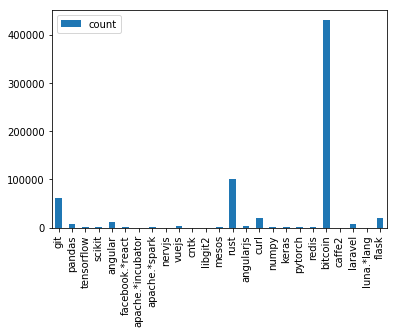

In [36]:
# Show barplot for the counts.
reddit_comments_df.plot.bar();

We notice that most of the values are within acceptable ranges. There are three main outliers:

- `git`: this is one of the oldest and most well-known projects. Seeing this many mentions is not surprising.
- `bitcoin`: Bitcoin seems to have several active communities on Reddit (e.g. r/Bitcoin, r/BitcoinBeginners, r/BitcoinMarkets, etc). Many of them are not related to the core, open-source Bitcoin project, but are about the cryptocurrency in general. In order to get more accurate results, we plan to update our code to count mentions in specific programming-related subreddits such as r/programming.
- `rust`: Rust also has a very active community on Reddit (r/Rust), although our results might also be polluted by the popular [Rust video game](https://store.steampowered.com/app/252490/Rust/). We should be able to get more accurate results with the same method highlighted above.

# 5. Plan Update

Based on the above analysis, we can specify our plan in a more detailed way:

### <span style='color:green'> 5.1 - Defining successful & unsucessful projects </span>
We take the 24 popular projects from the Gitential dataset as examples of successful open source projects. The success of a project can be determined based on e.g.:

- **Number of commits/authors**: the higher the number of commits and authors, the more people working on it. This high motivation of people can be caused by the high utlity that this project provides.
- **Number of issues (on Github) or questions and comments (in StackOverflow or Reddit) about this project**: this is an indicator that the project is popular and people are using it.
- **Number of comments (in Github) or answers (in StackOverflow) and the response time**: a low response time or a high number of replies can indicate that many people use the project.

By analysing these factors on the 24 projects given in the Gitential dataset and using our additional datasets to enrich it, we can get an absolute value range of the number of commits, issues, questions, comments and answers. Since these projects have different sizes (based on line of code) we can calculate a relative number for comparison.

###  <span style='color:green'>5.2 - How to answer the research questions and with which dataset?</span>
We take our research questions from milestone 1 and show possible ways to answer them, based on our improved knowledge after exploring our datasets. The listed columns of a dataset we could use for each question is not complete, but shows a starting point for our data analysis. We may obtain more possibilities and useful information from other columns during later steps.


- *How many contributors are there, and are there time patterns to when they submit their changes?*

**Gitential data**: we plan to look at the number of unique authors (`author_name` and `author_name_dedup`, whichever is not NaN) for each project, and analyze the `committer_time` for each person and globally.

---

- *Is there a certain roles distribution among contributors to the project? For example, do successful projects have people who focus on refactoring code, adding features or fixing bugs?*

**Gitential data**: we plan to answer this by analysing the commits data. For example, `loc_d`, `loc_i`, `comp_d`, and `comp_i` can be used to detect people who focus on refactoring code or enforce style guidelines. `nfiles` could identify people who focus on small or large amounts of files at once, which could indicate bug fixes/small features versus larger feature additions/overhauls. Commit messages (`message`) can be parsed to identify several types of commits. For example: commits that fix issues (e.g. by looking at keywords such as 'Closes' or 'Fixes'), or commits that merge another person's pull requests (by looking for 'Merges ...' commits).

---

- *Are there certain patterns to the commits, such as commit messages length, size or frequency of the commits, etc?*

**Gitential data**: we can analyse possible patterns in the columns `message`, `nfiles` (for the size of the commits) and `committer_time` (for the frequency).

---

- *Are contributors part of a small community/team (e.g. real-life development teams), or are they independent contributors?*

**Gitential data**: we plan to analyze this by checking `committer_email` and `committer_email_dedup` and parsing the domain of the email (e.g. people from the Microsoft team will have `@microsoft` emails), whereas more diverse people are more likely to have their unique email hosts or common email hosts (e.g. `@hotmail` or `@gmail`).

---

- *Can we relate the success / popularity to a responsive / helpful community (e.g. StackOverflow / Reddit subreddits)?*

**StackOverflow dataset**: we plan to count the number of questions related to each of these projects (by making use of `_Tags`), and compute the average response time (using `_CreationDate` and `_PostTypeId`, to get the difference between the question and the first answer). We also plan to check the response time of accepted responses (not just the first answer), by using the `_AcceptedAnswerId` column. Additionally, `_AnswerCount` can also be used as an indicator of a thriving community.

**Reddit dataset**: we plan to count the number of posts and comments about each project, as well as posts in a subreddit for projects that have a subreddit dedicated to them. We might have to focus on certain programming-related subreddits to avoid false matches.

---

- *Can we gain some insight from GitHub issues for a project? For example, the number of open/closed issues or the response time.*

**GitHub API issues**: we plan to do this by looking at the columns `state`, `closed_at` and `created_at` (time for resolution), as well as `created_at` / `parent` for the comments to get the response time.

---

- *Could sentimental analysis of commit messages or issue reports be meaningful? (GitHub API comments)*

**Gitential data**: we plan to analyze commit messages (`message`) with an Python library (NLTK).

**GitHub API comments**: similarly, we plan to analyze issue body texts (`body`).

---

- *Does the choice of programming language play a role in the success of a project?*

We were planning to check the `patches` Gitential datasets for this at first, but we decided to drop this idea after futher consideration, as a proper statistical analysis would probably require thousands of Git projects (24 data points is not sufficient, since this is a very simple and one-dimensional data point).

---

- *Similarly, can projects' licenses or codes of conduct provide us with some insight?*

We were planning to use the Github API to get data for this, but we decided to drop it as well for similar reasons as above.

---

- *Are contributors focused around certain parts of the project?*

**Gitential data**: we decided to postpone this for now due to potential time constraints, as we consider the other questions to be more important. If time allows it, we might be able to explore this at a later stage by checking the `patches` Gitential datasets.

###  <span style='color:green'> 5.3 - Does the retrieved data suit our project aim? </span>

With the above section in mind («*2. How to answer the research questions and with which dataset*»), we can say that we can answer most of our research questions with our retrieved data. Some columns of the data are not mentioned above, but this does not mean that they are useless. We may make use of these later in the analysis as they provide additional information.

To conclude, the retrieved data suits our project aim. In our presentation, we plan to answer each of our research questions in order to present a story that shows common patterns among successful projects.

###  <span style='color:green'>5.4 - Methods & mathematical details in later analysis</span>

**Descriptive statistics**
- Robust statistics: median, quartiles.
- Distribution: normal, heavy-tailed, poisson, exponential.
- Visual inspection: histograms, bar charts, boxplots.

**Quantifying uncertainty** 
- Error bars: standard deviation and confidence interval.
- Bootstrap resampling.

**Relating two variables**
- Correlation coefficients: pearson, spearman.

**Hypothesis testing**
- Testing the significance of null hypothesis to make conclusions.
- Using p-value.

**Classifier for sentiment analysis** (machine learning model)
- The Python library NLTK makes use of classifier algorithms to predict on the given test data set (Git commits and GitHub API comments) whether it is a positive or negative comment (we use two classes).

###  <span style='color:green'>5.5 - Not considered potential alternatives</span>

We are not considering the two datasets `blames` and `patches` in the Gitential data since we would like to focus on the commits based on our research questions. Commits are the most important part for the project and are the main contribution of people.

# 6. Answering the Research Questions

### <span style='color:green'> 6.1 - How many contributors are there for each repository? </span>

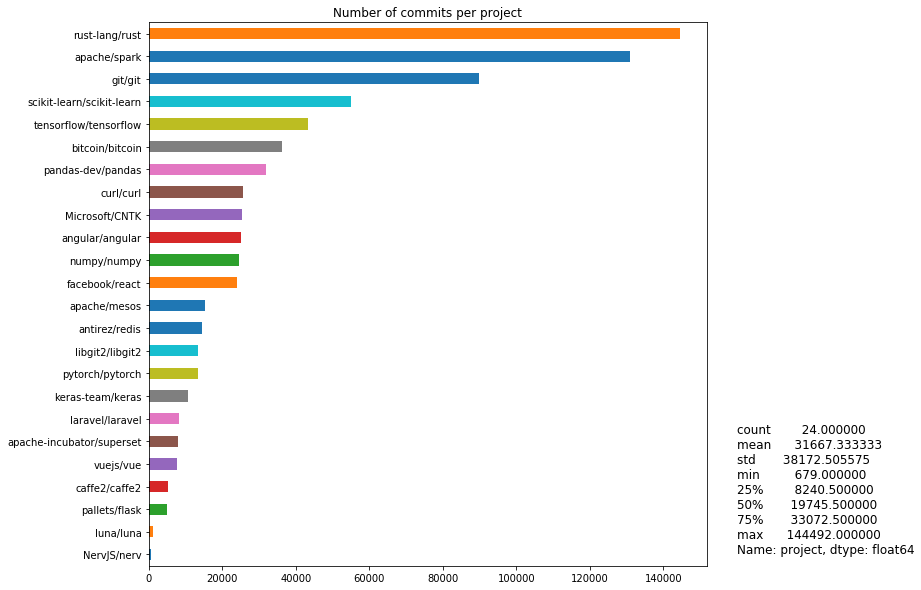

In [306]:
# Number of commits per project.
commits_count_by_project = commits_df.project.value_counts(ascending=True)
commits_count_by_project.plot.barh(figsize=(10, 10), title='Number of commits per project');
plt.text(160000, .05, str(commits_count_by_project.describe()), fontsize=12);

The above graph represents the number of commits per project. It can be noted that there is an exponential trend for the distribution. This illustrates the difference in size that exists between the projects. This is important to keep in mind for any later analysis step for valid conclusions to be drawn.

<span style="color:red">**Note:**</span> due to this difference in size, proportions (with respect to the attribute in question or to the project size) have to be used for the analysis.

---

<span style='color:green'>
    <h3>6.2 -</h3>
    <h3>(a) Are authors and committers the same?</h3>
    <h3>(b) If not, how do we explain the difference? Can this be attributed to a specific role such as "Supervising commits"?</h3>
</span>

---

<span style="color:green">6.2 - (a) Are authors and committers the same?</span>

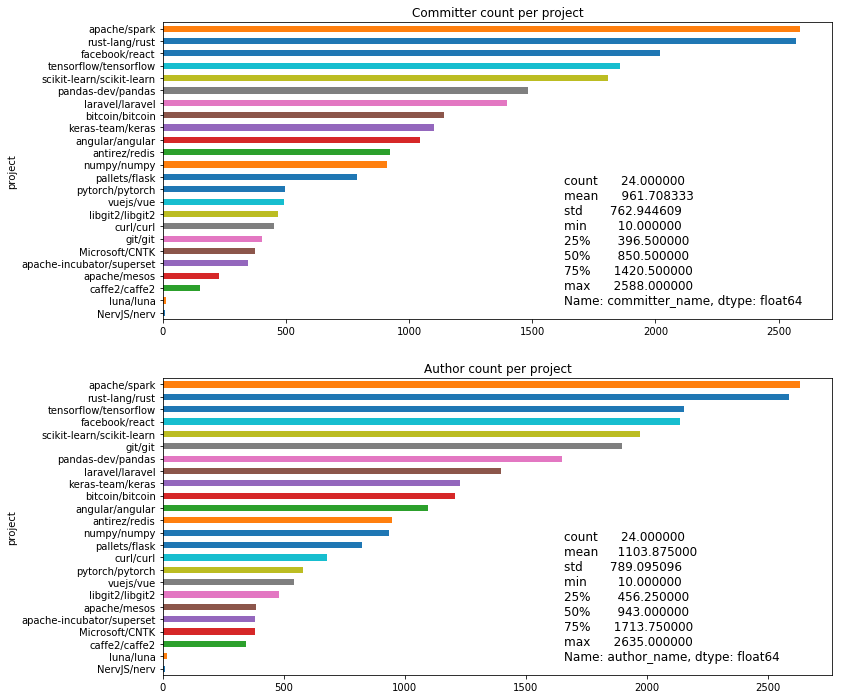

In [36]:
# Number of committers per project.
committer_count_by_project = commits_df[['project', 'committer_name']].drop_duplicates().groupby('project').committer_name.count().sort_values()

# Number of authors per project.
author_count_by_project = commits_df[['project', 'author_name']].drop_duplicates().groupby('project').author_name.count().sort_values()

# Committers vs authors.
fig, ax = plt.subplots(2, 1)
committer_count_by_project.plot.barh(figsize=(12, 12), ax=ax[0], title='Committer count per project')
author_count_by_project.plot.barh(ax=ax[1], title='Author count per project')
ax[0].text(.6, .05, str(committer_count_by_project.describe()), fontsize=12, transform=ax[0].transAxes)
ax[1].text(.6, .05, str(author_count_by_project.describe()), fontsize=12, transform=ax[1].transAxes);

Analyzing the distribution and the statistical parameters of the committer count and author count per project, it can be noticed that there is some difference, although it is minimal.

(Note that the exponential distribution is still present so the size must still be taken into consideration.)

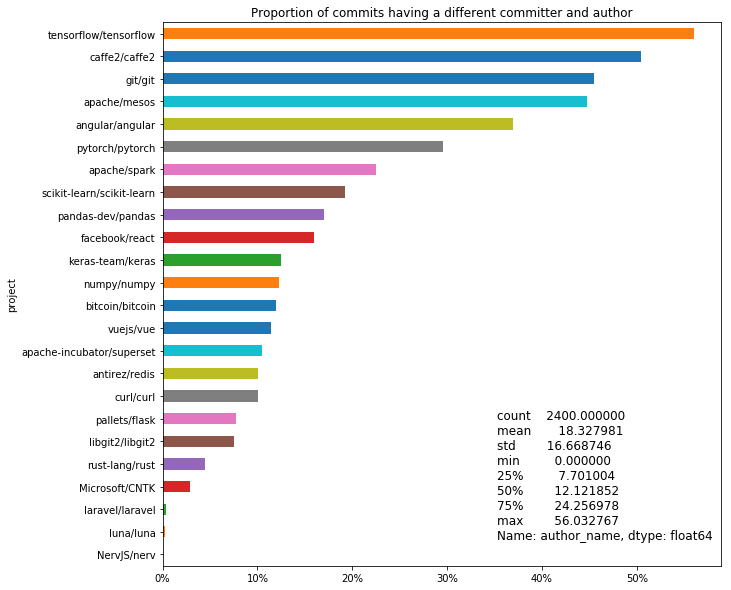

In [37]:
# Proportion of commits that have different author and committer.
diff_count_by_project = commits_df[commits_df.author_name != commits_df.committer_name].groupby('project').author_name.count()
diff_prop_by_project = diff_count_by_project / commits_df.groupby('project').author_name.count()
diff_prop_by_project = diff_prop_by_project.fillna(0)
diff_prop_by_project = diff_prop_by_project.sort_values()
ax = diff_prop_by_project.plot.barh(figsize=(10, 10), title='Proportion of commits having a different committer and author')
ax.set_xticklabels(['{:.0%}'.format(x) for x in ax.get_xticks()])
ax.text(.6, .05, str(diff_prop_by_project.describe() * 100), fontsize=12, transform=ax.transAxes);

Analyzing the distribution and the statistical parameters of the proportion of commits that have a different author and committer per project, it can be noticed that there some projects have a really high proportion (up to 56%!), while others have a very low proportion (0%). The mean is 18%.
We notice no clear trend between this and the author/committer count per project (for instance, `rust-lang/rust` has the most committers/authors but only has a proportion of around 5% when it comes to commits with a different committer and author.

However, even though there is no general trend, we might still gain some insight when it comes to role distribution by looking at the distribution more closely for each project.

---

<span style="color:green">6.2 - (b) If not, how do we explain the difference? Can this be attributed to a specific role such as "Supervising commits"?</span>
For each project, we now consider commits that have different author and committer versus the total of commits per project. The results are presented below. The aim is to test whether a relation exists between the number of commits of a project and having commits with different committer and author.

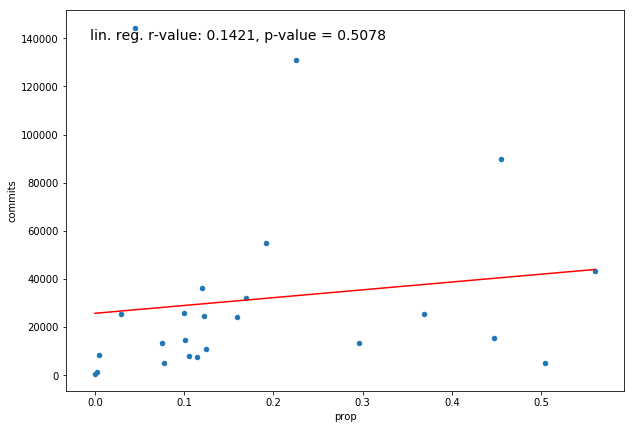

In [38]:
tmp = pd.DataFrame([diff_prop_by_project, commits_count_by_project]).T
tmp.columns = ['prop', 'commits']
#fig, ax = plt.subplots(1, 1)
tmp.plot(x='prop', y='commits', kind='scatter', figsize=(10, 7))
slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(tmp.prop, tmp.commits)
plt.plot(tmp.prop, intercept + slope * tmp.prop, 'r')
plt.text(0, .55, 'lin. reg. r-value: {:.4f}, p-value = {:.4f}'.format(r_value, p_value), fontsize=14, transform=ax.transAxes);

From the obtained scatter plot and fitted linear regression model (slope = 0.1421, p-value = 0.5078), **it can be seen that no strong relation exists between the two.**

For these commits (where the author is different then the committer), the proportion per committer is calculated and the top committer per project is presented in below.

In [39]:
# Proportion of commits for the top 1 committer per project, when the author is not the committer
tmp = commits_df[(commits_df.author_name != commits_df.committer_name)].groupby('project').apply(lambda x: x.committer_name.value_counts(normalize=True))
tmp = pd.DataFrame(tmp).reset_index()
tmp.columns = ['project', 'committer', 'proportion']
tmp.proportion *= 100
tmp.groupby('project').apply(lambda x: x.sort_values(by='proportion', ascending=False).head(1))

,,project,committer,proportion
project,,,,
Microsoft/CNTK,0,Microsoft/CNTK,Willi Richert,14.774282
angular/angular,59,angular/angular,Zhicheng Wang,20.294055
antirez/redis,189,antirez/redis,antirez,77.188146
apache-incubator/superset,211,apache-incubator/superset,Maxime Beauchemin,71.822542
apache/mesos,235,apache/mesos,Jie Yu,18.641597
apache/spark,275,apache/spark,Reynold Xin,9.639046
bitcoin/bitcoin,530,bitcoin/bitcoin,Wladimir J. van der Laan,15.811277
caffe2/caffe2,677,caffe2/caffe2,Facebook Github Bot,94.108587
curl/curl,690,curl/curl,Daniel Stenberg,55.058366


<span style="background:lightgreen">In short, these results provide **another common feature** among these **successful projects** and that is in relation to **supervising commits**.  
**Most of the proportions are above 30% which might indicate the presence of a certain role which might be supervising commits.**</span>

### <span style='color:green'> 6.3 - What can we learn from the frequency of the commits? </span>

In order to study the frequency of the commits, we first sort the commits for each project by time. We then compute **the interval between each two consecutive comments**. Studying this feature would allow us to obtain the frequency of commits per project.

The author time and committer time are both analyzed (for any possible insight).

In [40]:
# List of projects.
projects = list(commits_df['project'].drop_duplicates())
out = dict()
# For each project, compute the difference between consecutive (sorted by author time) commits.
for project in projects:
    tmp = list(commits_df[commits_df['project'] == project].author_time.sort_values())
    res = list()
    for i in range(0,len(tmp),2):
        if(i+1 < len(tmp)):
            res.append(tmp[i+1] - tmp[i])
    out[project] = res

# Get statistical measures for each project.
ans = pd.DataFrame(index=['count','mean','std','min','25%','50%','75%','max'])
for project in out.items():
    ans[project[0]] = pd.DataFrame(project[1]).describe()

In [41]:
ans

,Microsoft/CNTK,NervJS/nerv,angular/angular,antirez/redis,apache-incubator/superset,apache/mesos,apache/spark,bitcoin/bitcoin,caffe2/caffe2,curl/curl,...,libgit2/libgit2,luna/luna,numpy/numpy,pallets/flask,pandas-dev/pandas,pytorch/pytorch,rust-lang/rust,scikit-learn/scikit-learn,tensorflow/tensorflow,vuejs/vue
count,12693,339,12621,7222,3971,7667,65430,18151,2573,12852,...,6740,642,12276,2445,15998,6651,72246,27486,21607,3850
mean,0 days 01:25:13.678878,0 days 09:52:54.380530,0 days 01:10:24.395689,0 days 05:15:04.523262,0 days 02:53:32.350289,0 days 03:42:03.528759,0 days 00:31:46.869341,0 days 01:49:30.790865,0 days 04:57:16.582977,0 days 06:17:22.914410,...,0 days 05:37:50.320029,0 days 16:36:31.141744,0 days 05:48:15.925871,0 days 14:04:12.242126,0 days 02:28:17.530503,0 days 03:59:47.511351,0 days 00:27:46.262547,0 days 01:14:53.962162,0 days 00:49:56.169389,0 days 04:52:37.219480
std,0 days 08:53:52.944531,1 days 03:12:02.808493,0 days 03:51:59.418240,0 days 14:56:40.392424,0 days 08:39:20.638523,0 days 19:31:03.128570,0 days 05:40:09.876982,0 days 04:52:15.942103,1 days 16:42:20.607349,0 days 17:08:55.597366,...,0 days 18:04:21.758314,6 days 09:36:17.279585,0 days 22:42:48.936569,1 days 11:01:10.213847,0 days 15:41:16.618685,1 days 02:54:28.540150,0 days 01:43:34.569783,0 days 03:45:03.248626,2 days 09:33:55.163288,0 days 13:38:46.120697
min,0 days 00:00:00,0 days 00:00:11,0 days 00:00:00,0 days 00:00:00,0 days 00:00:00,0 days 00:00:00,0 days 00:00:00,0 days 00:00:00,0 days 00:00:00,0 days 00:00:00,...,0 days 00:00:00,0 days 00:00:00,0 days 00:00:00,0 days 00:00:00,0 days 00:00:00,0 days 00:00:00,0 days 00:00:00,0 days 00:00:00,0 days 00:00:00,0 days 00:00:00
25%,0 days 00:00:40,0 days 00:09:00,0 days 00:00:00,0 days 00:00:00,0 days 00:06:46.500000,0 days 00:00:30,0 days 00:00:43,0 days 00:01:17,0 days 00:08:18,0 days 00:05:09,...,0 days 00:06:08.750000,0 days 00:15:30.250000,0 days 00:02:33.750000,0 days 00:03:56,0 days 00:04:15,0 days 00:00:44,0 days 00:00:00,0 days 00:00:00,0 days 00:01:16,0 days 00:06:25.250000
50%,0 days 00:10:57,0 days 00:59:19,0 days 00:03:24,0 days 00:10:16,0 days 00:32:14,0 days 00:15:18,0 days 00:04:59,0 days 00:20:31,0 days 00:33:22,0 days 00:51:20,...,0 days 00:45:28.500000,0 days 01:15:19,0 days 00:40:50.500000,0 days 00:44:32,0 days 00:26:41,0 days 00:14:37,0 days 00:00:28,0 days 00:08:58.500000,0 days 00:07:20,0 days 00:42:00.500000
75%,0 days 00:42:13,0 days 06:28:59,0 days 00:40:53,0 days 02:56:29.750000,0 days 01:53:18.500000,0 days 01:38:04,0 days 00:16:13,0 days 01:32:33.500000,0 days 01:43:06,0 days 06:01:28.750000,...,0 days 03:51:22,0 days 07:47:51.750000,0 days 04:09:49.250000,0 days 10:05:33,0 days 01:39:53,0 days 01:02:51.500000,0 days 00:23:58.750000,0 days 00:50:24.750000,0 days 00:22:14.500000,0 days 03:55:31.500000
max,31 days 06:09:22,12 days 04:49:25,5 days 23:06:32,17 days 12:17:30,7 days 23:45:26,38 days 20:04:45,21 days 16:37:53,6 days 20:12:32,56 days 17:04:19,34 days 15:55:03,...,19 days 01:49:31,156 days 22:40:24,39 days 02:21:36,20 days 12:25:17,45 days 02:40:23,40 days 02:13:56,7 days 06:32:24,5 days 03:48:13,352 days 12:15:40,11 days 23:20:32


In [42]:
out = dict()
# For each project, compute the difference between consecutive (sorted by commit time) commits.
for project in projects:
    tmp = list(commits_df[commits_df['project'] == project].committer_time.sort_values())
    res = list()
    for i in range(0,len(tmp),2):
        if(i+1 < len(tmp)):
            res.append(tmp[i+1] - tmp[i])
    out[project] = res

# Get statistical measures for each project.
ans2 = pd.DataFrame(index=['count','mean','std','min','25%','50%','75%','max'])
for project in out.items():
    ans2[project[0]] = pd.DataFrame(project[1]).describe()

In [43]:
ans2

,Microsoft/CNTK,NervJS/nerv,angular/angular,antirez/redis,apache-incubator/superset,apache/mesos,apache/spark,bitcoin/bitcoin,caffe2/caffe2,curl/curl,...,libgit2/libgit2,luna/luna,numpy/numpy,pallets/flask,pandas-dev/pandas,pytorch/pytorch,rust-lang/rust,scikit-learn/scikit-learn,tensorflow/tensorflow,vuejs/vue
count,12693,339,12621,7222,3971,7667,65430,18151,2573,12852,...,6740,642,12276,2445,15998,6651,72246,27486,21607,3850
mean,0 days 01:25:18.136689,0 days 09:54:35.551622,0 days 01:10:57.768798,0 days 05:16:03.174743,0 days 02:45:06.554520,0 days 03:32:22.764445,0 days 00:32:16.348861,0 days 01:49:39.787119,0 days 04:28:19.532841,0 days 06:11:02.763460,...,0 days 06:33:38.973738,0 days 16:02:33.471962,0 days 05:47:55.577875,0 days 14:40:15.894069,0 days 02:25:43.309288,0 days 04:10:28.320703,0 days 00:27:13.830232,0 days 01:14:38.465837,0 days 00:26:16.800435,0 days 04:50:12.556363
std,0 days 08:59:24.730553,1 days 03:12:05.652615,0 days 03:59:35.941905,0 days 15:30:07.166047,0 days 09:01:56.167408,0 days 18:50:23.232607,0 days 06:08:04.164241,0 days 05:21:25.393207,1 days 14:40:09.968444,0 days 16:25:24.491614,...,2 days 05:51:15.774915,6 days 09:04:09.735129,0 days 23:05:19.221919,1 days 12:02:31.219085,0 days 15:43:25.414899,1 days 08:06:36.565599,0 days 01:51:18.757435,0 days 03:47:43.899510,0 days 01:18:05.954719,0 days 13:09:15.195840
min,0 days 00:00:00,0 days 00:00:11,0 days 00:00:00,0 days 00:00:00,0 days 00:00:00,0 days 00:00:00,0 days 00:00:00,0 days 00:00:00,0 days 00:00:00,0 days 00:00:00,...,0 days 00:00:00,0 days 00:00:00,0 days 00:00:00,0 days 00:00:00,0 days 00:00:00,0 days 00:00:00,0 days 00:00:00,0 days 00:00:00,0 days 00:00:00,0 days 00:00:00
25%,0 days 00:00:06,0 days 00:08:14.500000,0 days 00:00:01,0 days 00:00:08,0 days 00:03:18,0 days 00:00:05,0 days 00:00:22,0 days 00:00:14,0 days 00:04:52,0 days 00:04:42,...,0 days 00:00:24.750000,0 days 00:14:11,0 days 00:01:24,0 days 00:04:04,0 days 00:01:56,0 days 00:00:00,0 days 00:00:00,0 days 00:00:00,0 days 00:00:47,0 days 00:04:16
50%,0 days 00:08:17,0 days 01:00:06,0 days 00:06:14,0 days 00:08:45,0 days 00:23:10,0 days 00:05:49,0 days 00:04:17,0 days 00:12:52,0 days 00:30:24,0 days 00:47:47.500000,...,0 days 00:23:26.500000,0 days 01:13:50,0 days 00:32:57.500000,0 days 00:47:04,0 days 00:19:31.500000,0 days 00:08:31,0 days 00:00:00,0 days 00:05:33,0 days 00:05:45,0 days 00:33:28.500000
75%,0 days 00:40:43,0 days 06:50:43,0 days 00:40:56,0 days 02:36:54.750000,0 days 01:42:27.500000,0 days 01:15:28,0 days 00:15:47,0 days 01:22:57,0 days 01:40:21,0 days 05:41:30.500000,...,0 days 03:14:26.500000,0 days 07:14:45.250000,0 days 03:38:59.500000,0 days 11:09:17,0 days 01:31:48.750000,0 days 00:51:38,0 days 00:19:49,0 days 00:44:25.750000,0 days 00:19:26,0 days 03:40:40
max,31 days 06:09:22,12 days 04:51:46,5 days 13:19:39,17 days 12:17:30,7 days 23:45:26,38 days 20:04:45,26 days 10:57:13,8 days 04:45:28,56 days 17:04:19,32 days 01:28:59,...,119 days 04:41:30,157 days 01:15:14,39 days 02:21:36,19 days 22:21:20,45 days 02:40:23,51 days 23:07:18,7 days 06:32:24,3 days 23:43:41,2 days 04:33:33,11 days 23:20:32


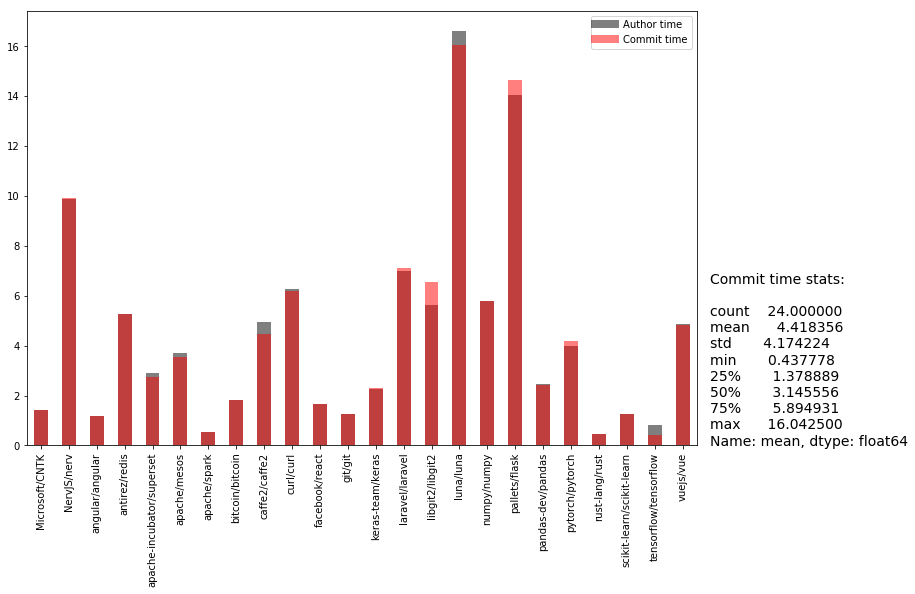

In [44]:
# Plot the means of the intervals per project for the author time and committer time (in hours).
ans.loc['mean'].apply(lambda td: td.seconds / 3600).plot(kind='bar', figsize=(12, 8), color='k', alpha=0.5)
ans2.loc['mean'].apply(lambda td: td.seconds / 3600).plot(kind='bar', figsize=(12, 8), color='r', alpha=0.5)
custom_lines = [Line2D([0], [0], color='k', alpha=0.5, lw=8), Line2D([0], [0], color='r', alpha=0.5, lw=8)]
plt.legend(custom_lines, ['Author time', 'Commit time']);
plt.text(24, 0, 'Commit time stats:\n\n{}'.format(
    ans2.loc['mean'].apply(lambda td: td.seconds / 3600).describe()), fontsize=14);

This graph shows the mean time between two consecutive commits (based on the author time, in black, or commit time, in red).

It can be seen that there is no significant difference. Furthermore, this shows that, on average, **a commit is made every day at the latest** (the maximum is 16 hours and the minimum 0.5 hour, with the mean being around 4.5 hours).

The available data suggests that, for successful projects, **the time between commits is at the latest around 16 hours (roughly a day)**. This can be seen as a common pattern in succesful projects.

However, it can be argued that this feature is not entirely reliable since the size of the commits is not taken into consideration. For example, larger commits changing hundreds of lines might have more time between them, as opposed to smaller but more frequent commits. In order to take this into consideration and test whether or not our conclusion is valid, the **ratio of the interval and the size of the commits (number of lines added or deleted) is computed**.

We believe this is a more reliable measure as it can be seen by the results obtained below.

In [45]:
# Only consider data points that have the relevant data, in order not to skew our results.
tmp1 = commits_df[(commits_df['loc_d'] != 0) & (commits_df['loc_i'] != 0)]

out = dict()
# For each project, compute the "normalized" difference between consecutive (sorted by author time) commits.
for project in projects:
    tmp = tmp1[tmp1['project'] == project][['author_time','loc_i','loc_d']].sort_values(by='author_time')
    tmp.index = range(tmp.shape[0])
    res = list()
    for i in range(0,len(tmp), 2):
        if i + 1 < len(tmp):
            tmp2 = tmp.loc[i+1, :]
            tmp3 = tmp.loc[i, :]
            # "Normalize" by dividing by the commit's size.
            res.append((tmp2['author_time'] - tmp3['author_time']) / (tmp2['loc_i'] + tmp2['loc_d'] + tmp3['loc_i'] + tmp3['loc_d']))

    out[project] = res

In [46]:
# Get statistical measures for each project.
ans3 = pd.DataFrame(index=['count','mean','std','min','25%','50%','75%','max'])
for project in out.items():
    ans3[project[0]] = pd.DataFrame(project[1]).describe()

ans3

,Microsoft/CNTK,NervJS/nerv,angular/angular,antirez/redis,apache-incubator/superset,apache/mesos,apache/spark,bitcoin/bitcoin,caffe2/caffe2,curl/curl,...,libgit2/libgit2,luna/luna,numpy/numpy,pallets/flask,pandas-dev/pandas,pytorch/pytorch,rust-lang/rust,scikit-learn/scikit-learn,tensorflow/tensorflow,vuejs/vue
count,9201,164,2661,5205,2872,3931,51498,13592,1679,7287,...,5065,518,9364,1093,11906,5176,58226,18585,14753,2831
mean,0 days 00:01:24.596028,0 days 00:37:34.731168,0 days 00:11:22.171695,0 days 00:20:11.220282,0 days 00:06:40.735456,0 days 00:09:49.451344,0 days 00:01:06.695695,0 days 00:03:06.887216,0 days 00:06:03.016260,0 days 00:29:01.971946,...,0 days 00:14:59.641770,0 days 00:16:46.831949,0 days 00:13:43.056493,0 days 01:37:45.107658,0 days 00:03:03.926114,0 days 00:09:16.826873,0 days 00:00:26.588869,0 days 00:02:47.490700,0 days 00:01:00.164291,0 days 00:12:11.007427
std,0 days 00:10:21.856433,0 days 02:09:33.994704,0 days 01:02:16.952408,0 days 01:40:13.107435,0 days 00:24:47.819054,0 days 00:58:57.100363,0 days 00:43:38.788089,0 days 00:14:19.786620,0 days 00:25:29.713055,0 days 01:33:36.185520,...,0 days 03:19:30.717380,0 days 02:16:04.031423,0 days 01:35:34.513842,0 days 05:45:41.403762,0 days 00:18:11.650226,0 days 01:54:01.854226,0 days 00:04:16.379733,0 days 00:13:34.201160,0 days 00:05:54.024426,0 days 00:46:54.833850
min,0 days 00:00:00,0 days 00:00:00.098569,0 days 00:00:00,0 days 00:00:00,0 days 00:00:00,0 days 00:00:00,0 days 00:00:00,0 days 00:00:00,0 days 00:00:00,0 days 00:00:00,...,0 days 00:00:00,0 days 00:00:00,0 days 00:00:00,0 days 00:00:00,0 days 00:00:00,0 days 00:00:00,0 days 00:00:00,0 days 00:00:00,0 days 00:00:00,0 days 00:00:00
25%,0 days 00:00:00.000200,0 days 00:00:19.903772,0 days 00:00:00,0 days 00:00:00,0 days 00:00:04.030281,0 days 00:00:00.538461,0 days 00:00:00.051683,0 days 00:00:00.148305,0 days 00:00:05.719262,0 days 00:00:13.668010,...,0 days 00:00:03.273584,0 days 00:00:08.900138,0 days 00:00:01.204753,0 days 00:00:06.821428,0 days 00:00:01.314825,0 days 00:00:00.044520,0 days 00:00:00,0 days 00:00:00.000302,0 days 00:00:00.052727,0 days 00:00:08.006047
50%,0 days 00:00:02.108695,0 days 00:01:41.850880,0 days 00:00:04.978128,0 days 00:00:17.697142,0 days 00:00:26.836442,0 days 00:00:19.775757,0 days 00:00:02.504906,0 days 00:00:06.576965,0 days 00:00:32.267241,0 days 00:02:32.242290,...,0 days 00:00:27.505894,0 days 00:00:37.219942,0 days 00:00:26.347500,0 days 00:02:10.512195,0 days 00:00:15.944852,0 days 00:00:08.542857,0 days 00:00:00.002564,0 days 00:00:05.536982,0 days 00:00:02.156146,0 days 00:00:48
75%,0 days 00:00:20.418604,0 days 00:13:21.334479,0 days 00:02:18.533333,0 days 00:04:09.142857,0 days 00:02:40.436428,0 days 00:03:03.062500,0 days 00:00:16.666666,0 days 00:01:03.446820,0 days 00:02:45.098595,0 days 00:17:49.798369,...,0 days 00:02:53.100775,0 days 00:02:50.877631,0 days 00:03:46.890654,0 days 00:33:33.333333,0 days 00:01:24.971618,0 days 00:00:58.440972,0 days 00:00:04.212500,0 days 00:00:59.312500,0 days 00:00:17.547619,0 days 00:04:53.314940
max,0 days 05:58:41.100000,0 days 20:24:37.285714,1 days 01:08:57.600000,2 days 03:17:56,0 days 06:46:29.846153,1 days 08:21:01,6 days 05:26:54.250000,0 days 08:42:36.909090,0 days 08:15:32.090909,1 days 11:54:48,...,9 days 02:44:06.750000,1 days 21:34:36.222222,2 days 17:49:12.437500,3 days 13:45:59.600000,0 days 15:17:27.250000,3 days 10:03:40.333333,0 days 06:23:41.090909,0 days 12:20:59.750000,0 days 04:18:13.333333,0 days 16:18:20.046511


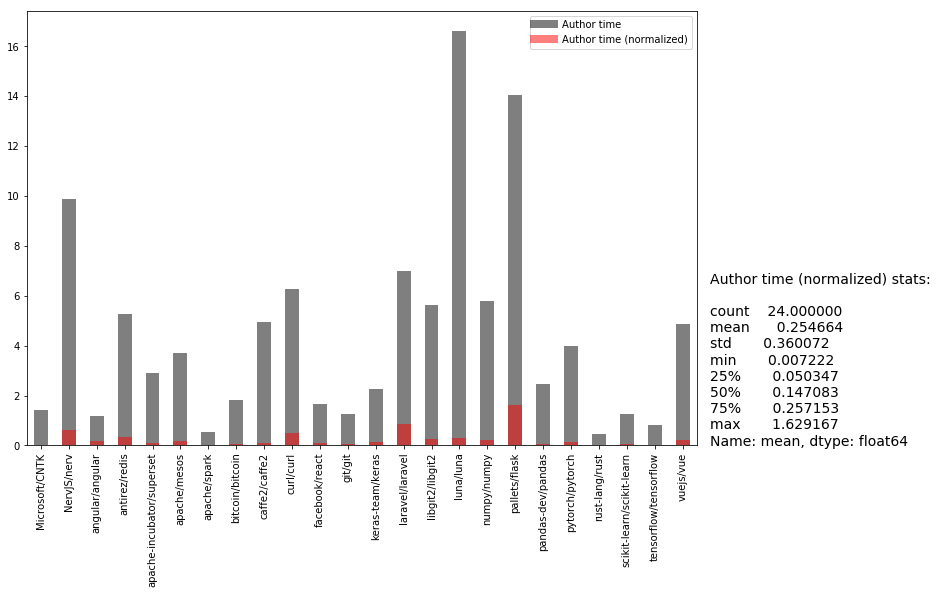

In [47]:
# Plot the normal and normalized means of the intervals per project for the author time (in hours).
ans.loc['mean'].apply(lambda td: td.seconds / 3600).plot(kind='bar', figsize=(12, 8), color='k', alpha=0.5)
ans3.loc['mean'].apply(lambda td: td.seconds / 3600).plot(kind='bar', figsize=(12, 8), color='r', alpha=0.5)
custom_lines = [Line2D([0], [0], color='k', alpha=0.5, lw=8), Line2D([0], [0], color='r', alpha=0.5, lw=8)]
plt.legend(custom_lines, ['Author time', 'Author time (normalized)'])
plt.text(24, 0, 'Author time (normalized) stats:\n\n{}'.format(
    ans3.loc['mean'].apply(lambda td: td.seconds / 3600).describe()), fontsize=14);

Considering the results of the normalized mean time intervals, it can be seen that the previously discussed frequency interval (less than 1 day) remains valid. In fact, **a new range can be obtained (from 0.5 minute and up to 1.6 hours per commit per line of committed code)**.

<span style="background:lightgreen">In short, these results provide **another common feature** among these **successful projects** and that is in relation to the **frequency of the commmits**. On average, a commit is made every 15 minutes per line of code. This represents the frequency/activity common to these successful project.</span>

### <span style='color:green'> 6.4 - Are there time patterns to when contributors submit their changes? </span>

For time pattern analysis, we were interested in two main features: **the weekly time patterns, and the daily time patterns**.

#### <span style='color:green'> Weekly time patterns </span>
In order to look at the weekly time patterns, we simply get **the distribution of the commit time and author time per project, and plot the result**. (In order to allow for an easy comparison, we use one plot per project, and overlay the author time and commit time.)

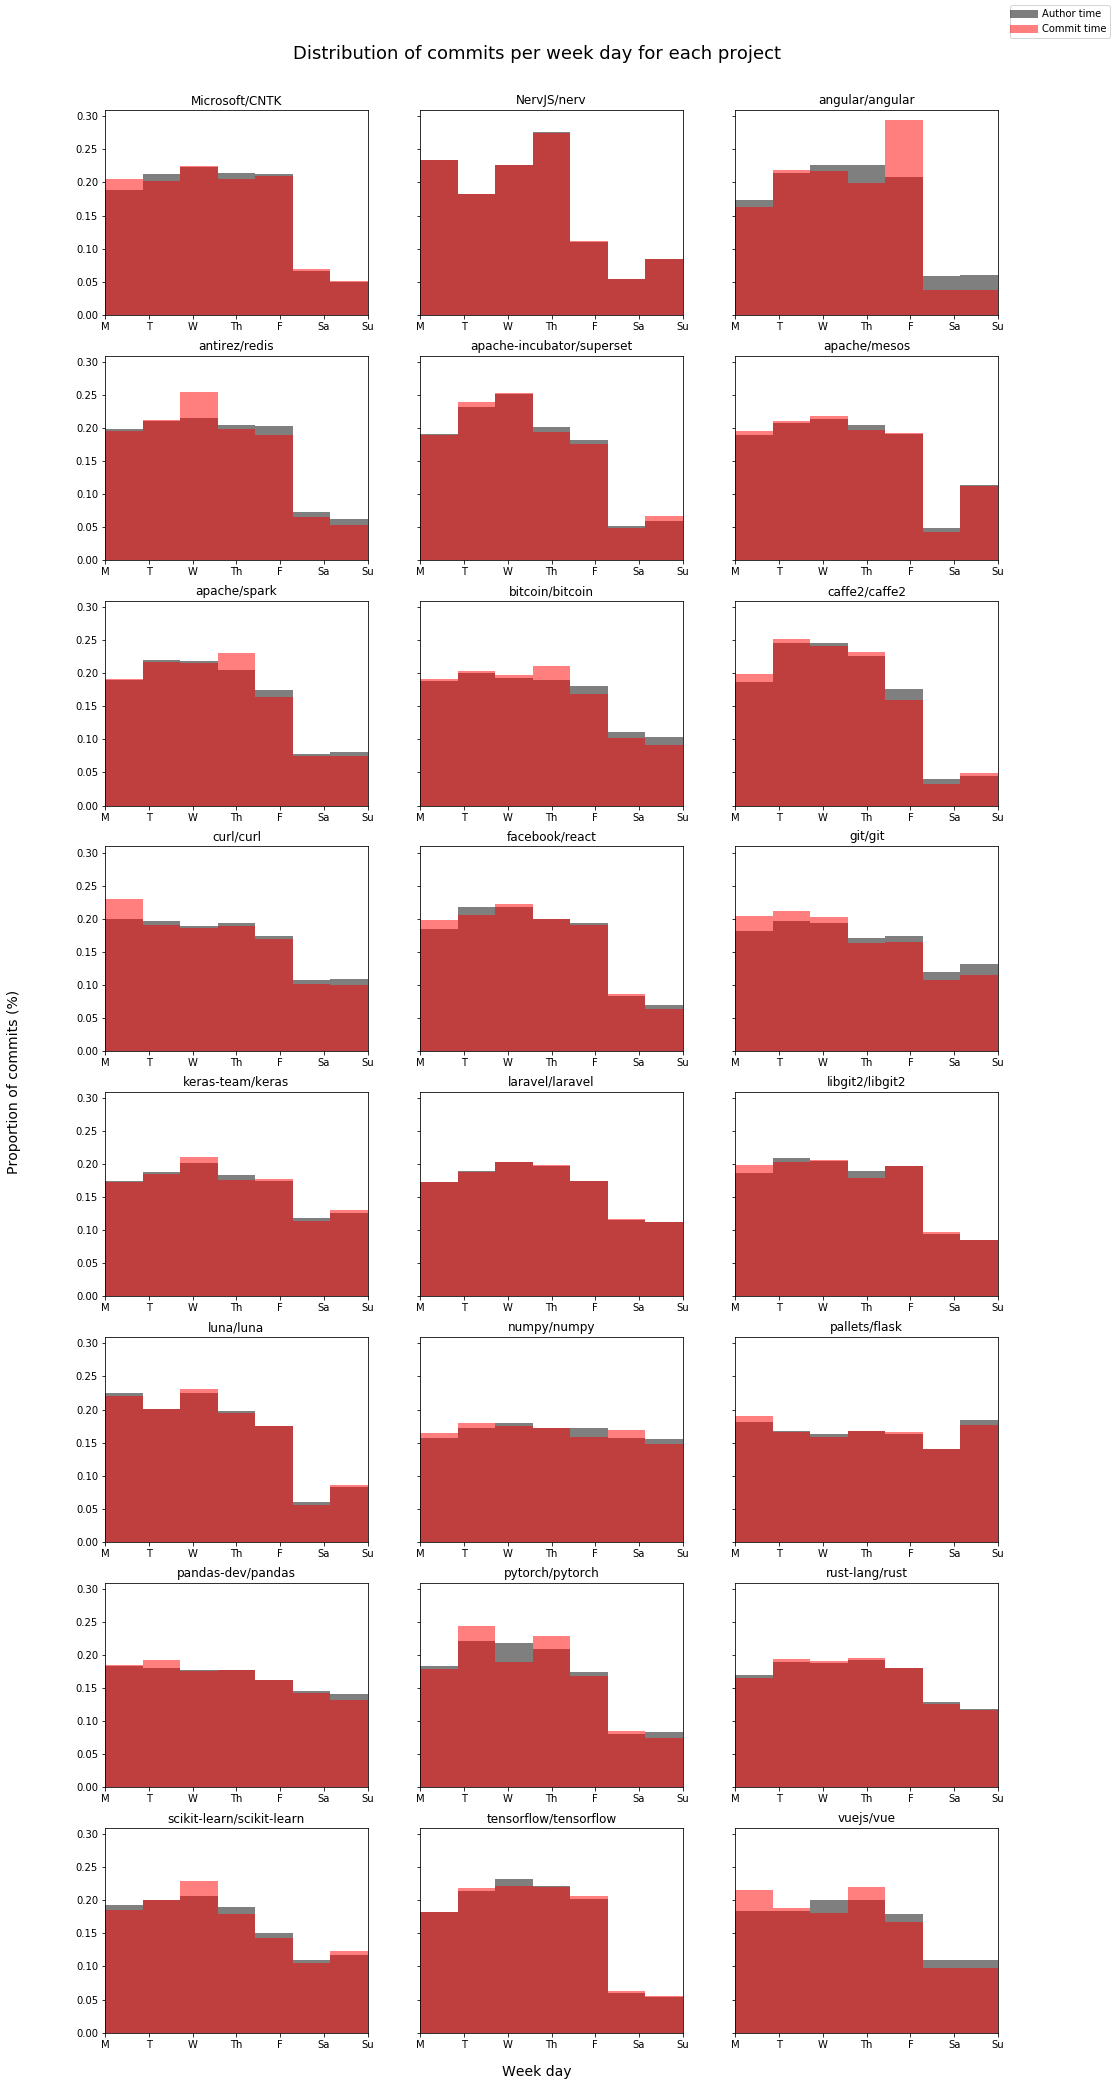

In [48]:
# For each project, get the day of the week distribution for author and commit times.
author_time_dayofweek = commits_df.groupby('project').author_time.apply(lambda x: [t.dayofweek for t in x])
committer_time_dayofweek = commits_df.groupby('project').committer_time.apply(lambda x: [t.dayofweek for t in x])

# Plot the results.
fig, ax = plt.subplots(8, 3, sharey=True)
fig.set_size_inches(16, 30)
ax = ax.flatten()
for i, project in enumerate(author_time_dayofweek.index):
    ax[i].hist(author_time_dayofweek[i], bins=7, color='k', alpha=0.5, density=True)
    ax[i].hist(committer_time_dayofweek[i], bins=7, color='r', alpha=0.5, density=True)
    ax[i].set_xticklabels(['M', 'T', 'W', 'Th', 'F', 'Sa', 'Su'])
    ax[i].margins(x=0)
    ax[i].set_title(project)

fig.subplots_adjust(top=0.95, bottom=0.06)
fig.text(0.5, 0.04, 'Week day', ha='center', fontsize=14)
fig.text(0.04, 0.5, 'Proportion of commits (%)', va='center', rotation='vertical', fontsize=14)
fig.suptitle('Distribution of commits per week day for each project', fontsize=18)
custom_lines = [Line2D([0], [0], color='k', alpha=0.5, lw=8), Line2D([0], [0], color='r', alpha=0.5, lw=8)]
fig.legend(custom_lines, ['Author time', 'Commit time']);

From the above plots, it can be seen that **the majority of projects are most active during weekdays, with a sharp drop during the weekends**. However, there are certain exceptions to this rule: `pandas-dev/pandas`, `numpy/numpy`, `pallets/flask`. This makes sense, as most people rest during the weekends.

However, we notice a sharper drop for a good chunk of the projects, such as `tensorflow/tensorflow`, `caffe2/caffe`, `luna/luna`, `Microsoft/CNTK` `angular/angular`, `antirez/redis`, `apache-incubator/superset` and `apache/spark`. **These are all owned/managed by companies/startups** (respectively Google Brain, Facebook, Luna, Microsoft, Google, Redis Labs, Apache and Apache). The sharp decline in these therefore makes sense, since the **core team is employed and does not work on weekends.**

The projects that do not show as sharp a decline are, for example: `pandas-dev/pandas`, `numpy/numpy` and `pallets/flask` as mentioned above, as well as `git/git`, `keras-team/keras`, `laravel/laravel` `rust-lang/rust` and `scikit-learn/scitkit-learn`. Except Rust (which is sponsored by mozilla), **these are all community-driven (although some might be sponsored)**. Keras also recently started to be officially backed by Google ([source](https://twitter.com/fchollet/status/820746845068505088)), although the project has existed since early 2015, so the mean showing this result also makes sense.

_<span style="color:red">Note:</span> we obtained this info by looking up the projects on Wikipedia and the projects' websites. For a data-driven analysis on the teams/communities behind each project, see section 6.5._

---

#### <span style='color:green'> Daily time patterns </span>
for the daily time patterns, we get **the distribution of the commit time and author time per project, and plot the result**. (Again, we use one plot per project and overlay the author time and commit time to allow for an easy comparison between the two.)

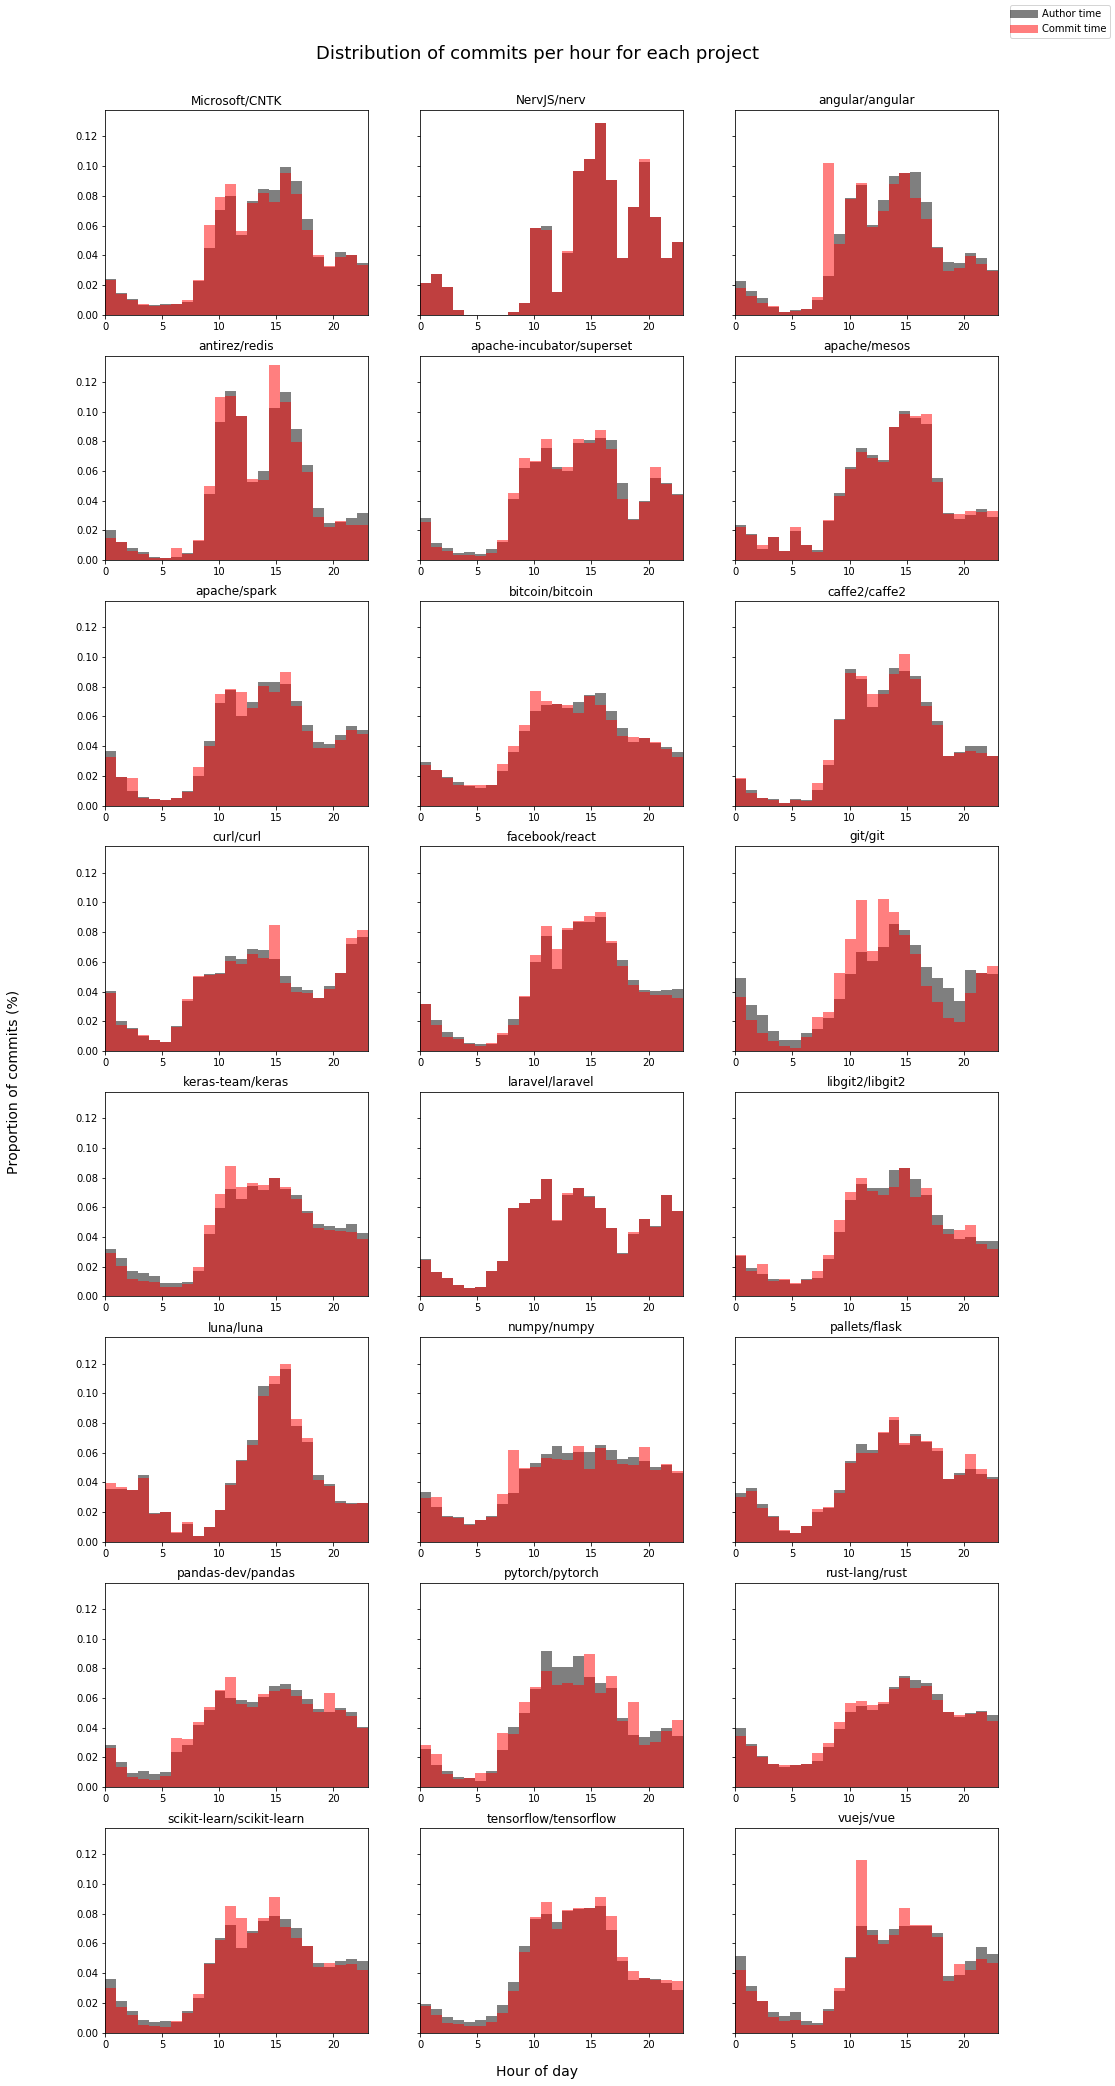

In [49]:
# For each project, get the day distribution (= per hour) for author and commit times.
author_time_hour = commits_df.groupby('project').author_time.apply(lambda x: [t.hour for t in x])
committer_time_hour = commits_df.groupby('project').committer_time.apply(lambda x: [t.hour for t in x])

# Plot the results.
fig, ax = plt.subplots(8, 3, sharey=True)
fig.set_size_inches(16, 30)
ax = ax.flatten()
for i, project in enumerate(author_time_hour.index):
    ax[i].hist(author_time_hour[i], bins=24, color='k', alpha=0.5, density=True)
    ax[i].hist(committer_time_hour[i], bins=24, color='r', alpha=0.5, density=True)
    ax[i].margins(x=0)
    ax[i].set_title(project)

fig.subplots_adjust(top=0.95, bottom=0.06)
fig.text(0.5, 0.04, 'Hour of day', ha='center', fontsize=14)
fig.text(0.04, 0.5, 'Proportion of commits (%)', va='center', rotation='vertical', fontsize=14)
fig.suptitle('Distribution of commits per hour for each project', fontsize=18)
custom_lines = [Line2D([0], [0], color='k', alpha=0.5, lw=8), Line2D([0], [0], color='r', alpha=0.5, lw=8)]
fig.legend(custom_lines, ['Author time', 'Commit time']);

From the above graph, it can be noticed that **all projects follow a similar daily time distribution**, where the activity increases to **reach a peak, then decreases constantly and hits a minimum for 6 to 8 hours** or so.

This corresponds to **most of the commits happening during the working period**, with the least activity happening during the evening and at night. This makes sense for the following reasons:

1. For **team-driven projects**, a lot of the work will be happening during the **work hours**.
2. For **other projects** and contributors in general, the contributors will also be following **daily schedules** (i.e. they sleep at night).

While projects will have contributors from all around the world, the majority is likely to be from specific countries (e.g. China, India and the US are respectively ranked 1st, 2nd and 3rd in terms of Internet users, [source](https://en.wikipedia.org/wiki/List_of_countries_by_number_of_Internet_users)) or specific to that project (e.g. `NervJS/nerv` seems to be driven by a Chinese community).

### <span style='color:green'> 6.5 - Are contributors part of certain communities/teams (e.g. real-life development teams)? </span>

In order to find out if some **projects are heavily contributed to by specific communities or teams**, we analyze the author and committer emails as such:

1. We **extract the domain** for each email (e.g. `example\@gmail.com` gives `gmail.com`).  
   We only keep up to one subdomain (e.g. `example\@machinename.northamerica.redmond.corp.microsoft.com` becomes `corp.microsoft.com`), as keeping more would potentially make each domain too specific.
2. We compute the **proportion of commits for each domain** per project.
3. We **drop "common" email providers** that are freely available to all users (e.g. `gmail.com`, `hotmail.com`, `yahoo.com`), since those **cannot be used to identify specific communities or teams**.
4. For each project, we plot the **top 5 domains** (with the highest proportion of commits) that have also contributed **at least 1% of the project's commits**.

In [50]:
REGEX_LEADING_DOTS = re.compile(r'^\.+')
# Very common domains.
common_domains = [
    # From <https://github.com/mailcheck/mailcheck/wiki/List-of-Popular-Domains>
    'aol.com', 'att.net', 'comcast.net', 'facebook.com', 'gmail.com', 'gmx.com', 'googlemail.com', 'google.com', 'hotmail.com', 'hotmail.co.uk', 'mac.com', 'me.com', 'mail.com', 'msn.com', 'live.com', 'sbcglobal.net', 'verizon.net', 'yahoo.com', 'yahoo.co.uk', 'email.com', 'fastmail.fm', 'games.com', 'gmx.net', 'hush.com', 'hushmail.com', 'icloud.com', 'iname.com', 'inbox.com', 'lavabit.com', 'love.com', 'outlook.com', 'pobox.com', 'protonmail.com', 'rocketmail.com', 'safe-mail.net', 'wow.com', 'ygm.com', 'ymail.com', 'zoho.com', 'yandex.com', 'bellsouth.net', 'charter.net', 'cox.net', 'earthlink.net', 'juno.com', 'btinternet.com', 'virginmedia.com', 'blueyonder.co.uk', 'freeserve.co.uk', 'live.co.uk', 'ntlworld.com', 'o2.co.uk', 'orange.net', 'sky.com', 'talktalk.co.uk', 'tiscali.co.uk', 'virgin.net', 'wanadoo.co.uk', 'bt.com', 'sina.com', 'sina.cn', 'qq.com', 'naver.com', 'hanmail.net', 'daum.net', 'nate.com', 'yahoo.co.jp', 'yahoo.co.kr', 'yahoo.co.id', 'yahoo.co.in', 'yahoo.com.sg', 'yahoo.com.ph', '163.com', '126.com', 'aliyun.com', 'foxmail.com', 'hotmail.fr', 'live.fr', 'laposte.net', 'yahoo.fr', 'wanadoo.fr', 'orange.fr', 'gmx.fr', 'sfr.fr', 'neuf.fr', 'free.fr', 'gmx.de', 'hotmail.de', 'live.de', 'online.de', 't-online.de', 'web.de', 'yahoo.de', 'libero.it', 'virgilio.it', 'hotmail.it', 'aol.it', 'tiscali.it', 'alice.it', 'live.it', 'yahoo.it', 'email.it', 'tin.it', 'poste.it', 'teletu.it', 'mail.ru', 'rambler.ru', 'yandex.ru', 'ya.ru', 'list.ru', 'hotmail.be', 'live.be', 'skynet.be', 'voo.be', 'tvcablenet.be', 'telenet.be', 'hotmail.com.ar', 'live.com.ar', 'yahoo.com.ar', 'fibertel.com.ar', 'speedy.com.ar', 'arnet.com.ar', 'yahoo.com.mx', 'live.com.mx', 'hotmail.es', 'hotmail.com.mx', 'prodigy.net.mx', 'yahoo.com.br', 'hotmail.com.br', 'outlook.com.br', 'uol.com.br', 'bol.com.br', 'terra.com.br', 'ig.com.br', 'itelefonica.com.br', 'r7.com', 'zipmail.com.br', 'globo.com', 'globomail.com', 'oi.com.br',
    # Additional common emails from our dataset
    'noreply.github.com', 'localhost'
]

def get_domain(email):
    '''Extract and return the domain (with up to one subdomain) from a given email.'''
    if not '@' in email:
        return None
    extracted = tldextract.extract(email)
    result = '{}.{}.{}'.format('.'.join(extracted.subdomain.split('.')[-1:]), extracted.domain, extracted.suffix)
    result = re.sub(REGEX_LEADING_DOTS, '', result)
    return result


# Get the results for committer emails.
committer_domain = commits_df.copy()#[commits_df.committer_email.str.contains('@')].copy()
# Extract domain.
committer_domain['committer_domain'] = committer_domain.committer_email.apply(get_domain)
# Compute proportion.
committer_domain_prop = committer_domain.groupby(['project', 'committer_domain']).size()
committer_domain_prop = committer_domain_prop.groupby(level=0).apply(lambda x: 100 * x / float(x.sum()))
# Remove common emails.
committer_domain_prop = committer_domain_prop[~committer_domain_prop.index.get_level_values('committer_domain').isin(common_domains)]

# Get the results for author emails.
author_domain = commits_df.copy()#[commits_df.author_email.str.contains('@')].copy()
author_domain['author_domain'] = author_domain.author_email.apply(get_domain)
author_domain_prop = author_domain.groupby(['project', 'author_domain']).size()
author_domain_prop = author_domain_prop.groupby(level=0).apply(lambda x: 100 * x / float(x.sum()))
author_domain_prop = author_domain_prop[~author_domain_prop.index.get_level_values('author_domain').isin(common_domains)]

		Proportion of commits per domain for committers/authors (showing only non-common domains)


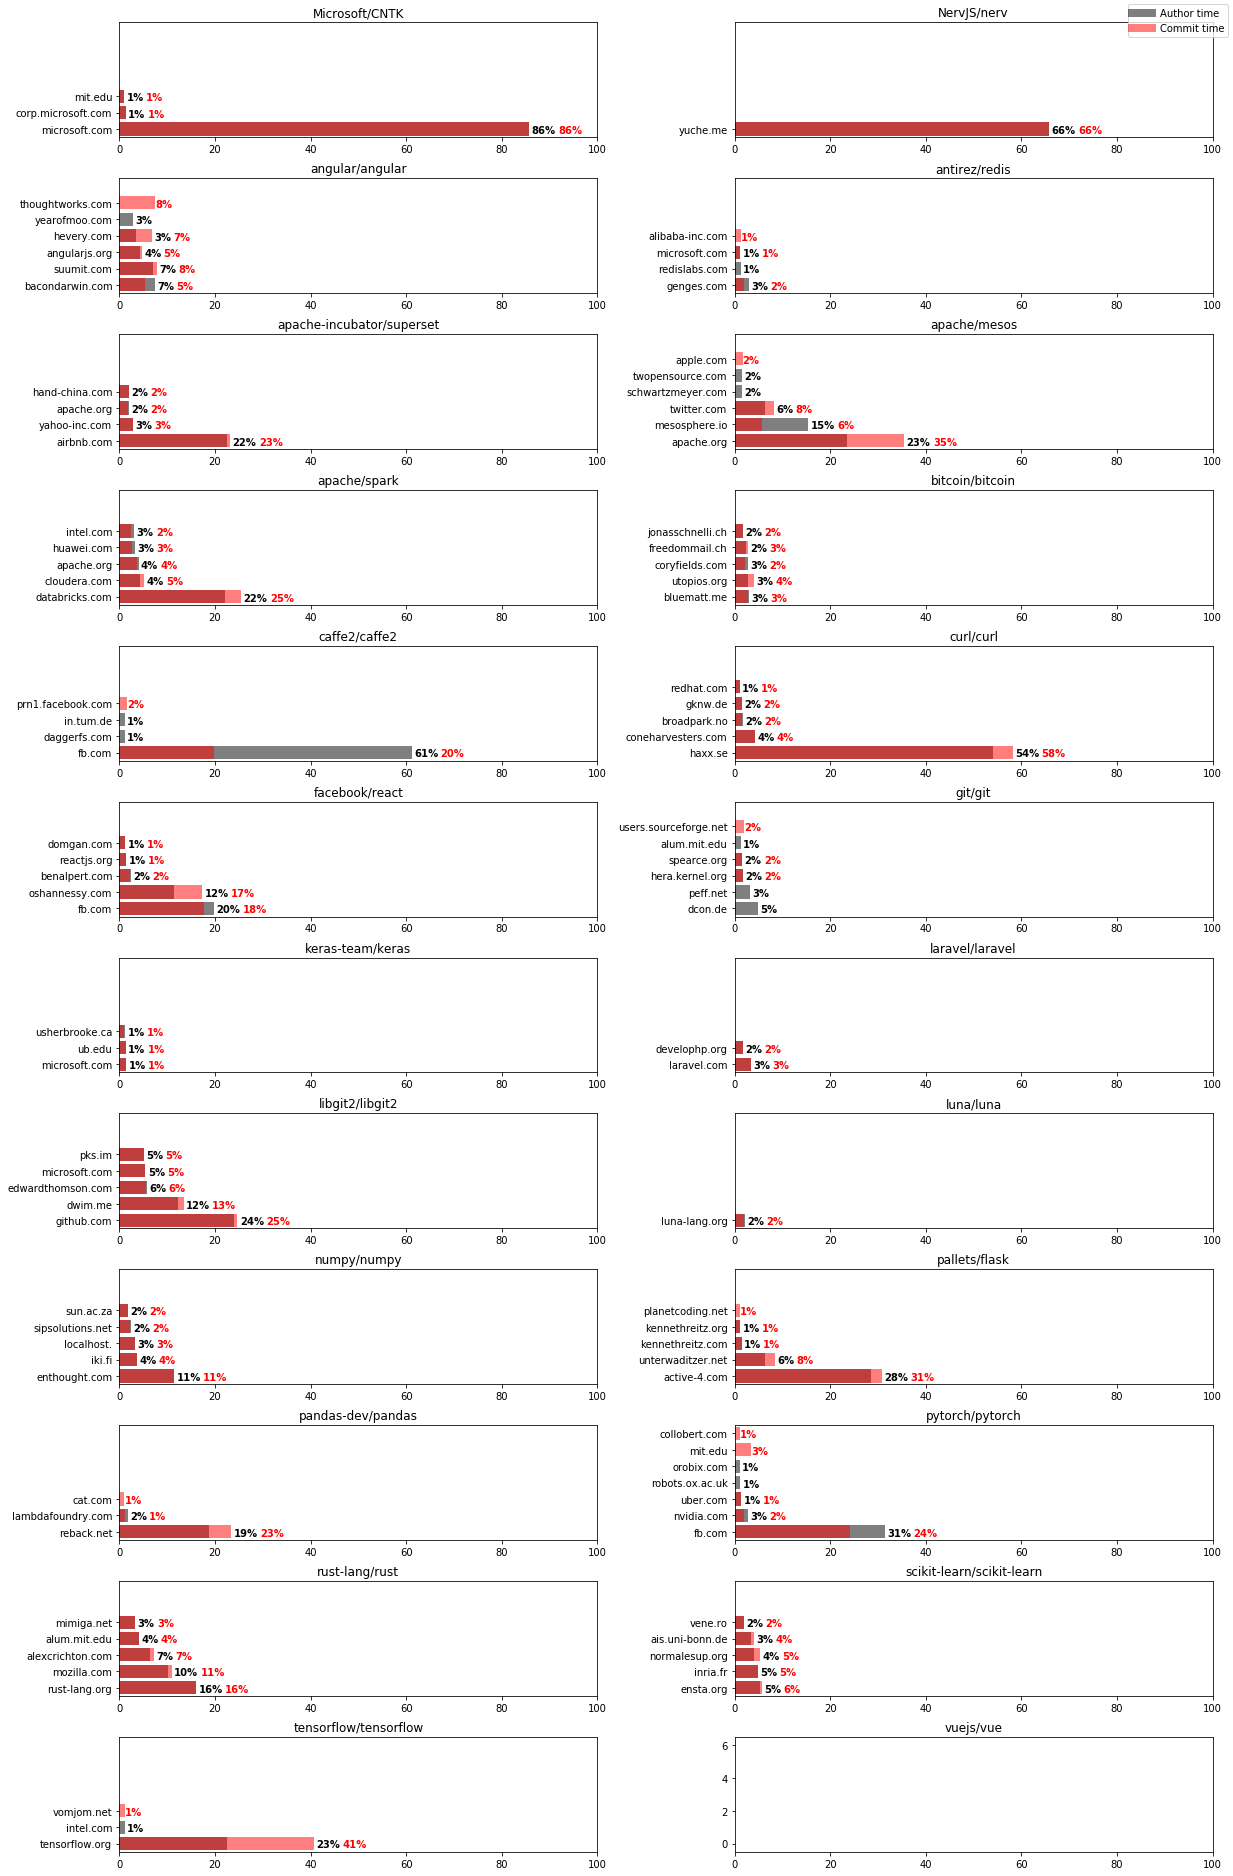

In [51]:
# Plot the results.
fig, ax = plt.subplots(12, 2)
fig.set_size_inches(16, 26)
ax = ax.flatten()

print('\t\tProportion of commits per domain for committers/authors (showing only non-common domains)')
fig.tight_layout(w_pad=10, h_pad=2)
custom_lines = [Line2D([0], [0], color='k', alpha=0.5, lw=8), Line2D([0], [0], color='r', alpha=0.5, lw=8)]
fig.legend(custom_lines, ['Author time', 'Commit time'])
for i, project in enumerate(author_domain_prop.index.get_level_values('project').unique()):
    # Plot author emails results.
    df_author = pd.DataFrame(author_domain_prop[author_domain_prop.index.get_level_values('project') == project], columns=['prop']).reset_index()
    df_author = df_author[df_author.prop > 1]  # Only keep domains that have at least 1% of commits.
    df_author = df_author.sort_values(by='prop', ascending=False).head(5)
    ax[i].barh(df_author.author_domain, df_author.prop, alpha=0.5, color='k')
    # Plot committer emails results.
    df_committer = pd.DataFrame(committer_domain_prop[committer_domain_prop.index.get_level_values('project') == project], columns=['prop']).reset_index()
    df_committer = df_committer[df_committer.prop > 1]
    df_committer = df_committer.sort_values(by='prop', ascending=False).head(5)
    ax[i].barh(df_committer.committer_domain, df_committer.prop, alpha=0.5, color='r')
    # Display the %ages near bar.
    bars_vals = pd.merge(df_author, df_committer, left_on='author_domain', right_on='committer_domain', how='outer')
    for pos, val in enumerate(bars_vals.iterrows()):
        pos_x = np.nanmax([0, val[1].prop_x, val[1].prop_y])
        offset = 0
        if not np.isnan(val[1].prop_x):
            text_author = '{:.0f}%'.format(val[1].prop_x)
            offset = 6 if len(text_author) == 3 else 4.5
            ax[i].text(pos_x + .5, pos - .25, text_author, color='k', fontweight='bold')
        if not np.isnan(val[1].prop_y):
            text_committer = '{:.0f}%'.format(val[1].prop_y)
            ax[i].text(pos_x + offset, pos - .25, text_committer, color='r', fontweight='bold')
    # Common plot settings.
    ax[i].set_ylim(-.5, 6.5)
    ax[i].set_xlim(0, 100)
    ax[i].set_title(project)

- `tensorflow/tensorflow`: (owned/managed by Google Brain) contributors from `tensorflow.org` have authored 23% of the project's commits, and have committed 41%.
- `caffe2/caffe2`: (owned/managed by Facebook) Facebook contributors have authored 20% and committed 61% of the project's commits.
- `luna/luna`: (owned/managed by Luna) `luna-lang.org` members have authored a couple of percents of the project's commits.
- `Microsoft/CNTK`: (owned/managed by Microsoft) Microsoft employees make up 87% of the commits' authors.
- `angular/angular`: (owned/managed by Google) a lot of teams seem to contribute to Angular at first glance, with the Angular team itself authoring a good chunk (5%). Researching this further, however, shows that `yearofmoo.com`, `hevery.com`, `bacondarwin.com` and `suumit.com` all belong to Google/Angular team members ([matsko](https://github.com/matsko), [mhevery](https://github.com/mhevery), [petebacondarwin](https://github.com/petebacondarwin), [vicb](https://github.com/vicb)), which brings the total up from 5% to 25% for authoring and 28% for comitting!  
  A few contributors from `thoughtworks.com` also make up 8% of commits' authors. They seem to be (independent) heavy users of Angular who contribute to it to improve it.
- `antirez/redis`: (owned/managed by Redis Labs) `redislabs.com` and `genges.com` ([belongs to Matt Stancliff](https://twitter.com/mattsta/status/250693019685224448), who used to be a [major contributor](https://redis.io/documentation)) make up around 2% and 5% of authors and committers. We also notice noticeable contributions from Alibaba and Microsoft (1% each), who probably make use of Redis and contribute back some of their internal changes/improvements.
- `apache-incubator/superset`: (owned/managed by Airbnb/Apache) `airbnb.com` and `apache.org` make up around 25% of authors/committers, with some important contributions from Yahoo Inc (3%) and hand-china.com (2%) employees. (With the latter contributing improvements according to their own needs, [example](https://github.com/apache/incubator-superset/issues/1515).)
- `apache/spark`: (owned/managed by Apache/Databricks) `apache.org` and `databricks.com` contributors author 26% and commit 29% of the project's commits. Other companies, such as Intel, Huawei and Cloudera contribute  to it as well (each authoring between 3% and 5% of the project's commits). All of these companies make use of Apache Spark (e.g. [Intel](https://software.intel.com/en-us/articles/bigdl-distributed-deep-learning-on-apache-spark), [Huawei](https://databricks.com/blog/2015/06/09/huawei-embraces-open-source-apache-spark.html), [Cloudera](https://www.cloudera.com/products/open-source/apache-hadoop/apache-spark.html)), so it makes sense for them to contribute to it.

The projects that do not show as sharp a decline are, for example: pandas-dev/pandas, numpy/numpy and pallets/flask as mentioned above, as well as git/git, keras-team/keras, laravel/laravel rust-lang/rust and scikit-learn/scitkit-learn. Except Rust (which is sponsored by mozilla), these are all community-driven (although some might be sponsored). Keras also recently started to be officially backed by Google (source), although the project has existed since early 2015, so the mean showing this result also makes sense.

- `pandas-dev/pandas`: `reback.net`, owned by a [core developer/maintainer](https://webcache.googleusercontent.com/search?q=cache:VSHE87_cRiIJ:https://www.anaconda.com/people/jeff-reback+&cd=17&hl=en&ct=clnk&gl=ch&client=firefox-b-ab) of pandas Jeff Reback and `lambdafoundry.com`, a company that [develops pandas](https://www.crunchbase.com/organization/lambda-foundry), make up 21%/24% of the commits' authors/committers. It also looks like the famous Cat (`cat.com`) makes use of pandas, as they're behind 1% of the project's commits!
- `numpy/numpy`: 
- `pallets/flask`:
- `git/git`:
- `keras-team/keras`:
- `laravel/laravel`:
- `rust-lang/rust`:
- `scikit-learn/scikit-learn`:

<span style="background:lightgreen">TODO: ADD CONCLUSION HERE</span>

In [52]:
commits_df[commits_df.committer_email.str.endswith('reback.net')].head(5)

,project,age,author_email,author_name,author_time,committer_email,committer_name,committer_time,comp_d,comp_i,delay,loc_d,loc_i,message,ndiffs,nfiles,squashof
id,,,,,,,,,,,,,,,,,
804eaaedc86a1e5989ae7cc3476b729ae9ad8cf4,pandas-dev/pandas,-1,j***@reback.net,Jeff Reback,2012-11-11 16:09:46,j***@reback.net,Jeff Reback,2012-11-11 16:09:46,24,32,0,10,15,in core/frame.py\n\nchanged method __getitem__...,1,2,-1
540fafd32f1a4a93c79ab3cec190c47e8ebcfcd5,pandas-dev/pandas,-1,j***@reback.net,Jeff Reback,2012-11-11 16:44:27,j***@reback.net,Jeff Reback,2012-11-11 16:44:27,23,8,0,6,5,relaxed __setitem__ restriction on boolean ind...,1,2,-1
030bc669b0a338deb35773612472a76dbf2ae9dd,pandas-dev/pandas,-1,j***@reback.net,Jeff Reback,2012-11-11 17:31:33,j***@reback.net,Jeff Reback,2012-11-11 17:31:33,4,2,0,2,2,"fixed file modes for core/frame.py, test/test_...",1,2,-1
8034116f41d642b8c16232ca0c971ae110072e42,pandas-dev/pandas,-1,j***@reback.net,Jeff Reback,2012-11-13 12:44:01,j***@reback.net,Jeff Reback,2012-11-13 12:44:01,30,5,0,20,2,in core/frame.py\n\nremoved mask method\nmade ...,1,2,-1
a4143469a961ccc9740a292c84b27c00d9674425,pandas-dev/pandas,-1,j***@reback.net,Jeff Reback,2012-11-13 12:56:09,j***@reback.net,Jeff Reback,2012-11-13 12:56:09,0,45,0,0,30,added back mask method that does condition inv...,1,2,-1


### <span style='color:green'> 6.6 - Is there a certain roles distribution among contributors to the project? For example, do successful projects have people who focus on refactoring code, adding features or fixing bugs? </span>

In order to try to answer this question, features from the commits data will be analyzed to identify the **presence of a role in the projects** in question. **The features chosen relate to the function of the role** in question. 


*<span style='color:green'> Analysis of the number of lines removed/added (per author per project): </span>*

For each commit, the number of lines **removed** (*loc_d*) and the number of lines **added** (*loc_i*) is provided. The **following steps** were then performed:

- For each commit, the **net number of lines changed** is computed (`number of lines removed - number of lines added`).
- For **each author, the net lines changed** for all of his/her commits are computed.
- For **each author, the total number of lines** added / removed is computed (amount of work done by author, needed to determine the threshold to decide if the author has a higher tendency to remove code or add it)
- For each project, find the **number of authors that have lower than 10% of their total number of lines changed.**(i.e. authors that have a tendency to add/remove code). The decision of using a threshold related to each author was chosen because taking a constant value (for example 'less than 0') would have **introduced a lot of false positives**. *For example, an author with a net of 1 would be considered in the 'removing lines' group; however, he/she has an equal tendency to add or remove lines*. Thus, considering a flexible threshold customized for each author is a more logical approach.
- For each project, the **percentage of authors with a tendency to remove code** is computed.

Note: in order to consider repeat contributors and ignore very minor contributors (meaning we can't really assign them to a role), we ignore authors with less than 3 commits.

In [188]:
# calculate net difference in number of lines per commit
commits_df['net_diff_lines'] = commits_df['loc_d'] - commits_df['loc_i']
# calculate the number of lines changed for each author over all his commits
net_per_author = commits_df[(commits_df['loc_d'] != 0) & (commits_df['loc_i'] != 0)].groupby(['project','author_name']).net_diff_lines.sum()

# calculate total number of lines changed per author (loc_d + loc_i)
commits_df['total_lines'] = commits_df['loc_d'] + commits_df['loc_i']
# get the number of lines changed for each author over all his commits
total_per_author = commits_df[(commits_df['loc_d'] != 0) & (commits_df['loc_i'] != 0)].groupby(['project','author_name']).total_lines.sum()

In [189]:
# join the data into a dataframe with author name for index
res = pd.DataFrame(net_per_author.values, index = net_per_author.index, columns = ['net_per_author'])
res['total_per_author_10_%'] = total_per_author.values * 0.1
res['decision'] = res['total_per_author_10_%'] - res['net_per_author']
res.head()

net_per_author  total_per_author_10_%  \
project        author_name                                                
Microsoft/CNTK                               -40                   30.8   
               Aayush Garg                 -3563                 1523.5   
               Abhik Lahiri               -15683                13418.7   
               Adalberto Foresti           -3369                 1244.3   
               Alexey                        -12                    1.6   

                                  decision  
project        author_name                  
Microsoft/CNTK                        70.8  
               Aayush Garg          5086.5  
               Abhik Lahiri        29101.7  
               Adalberto Foresti    4613.3  
               Alexey                 13.6

In [268]:
loc_df = commits_df.groupby(['project', 'author_name']).author_name.count()
loc_df = pd.DataFrame(loc_df[loc_df > 3])
loc_df.columns = ['commits']
loc_df = loc_df.join(res, how='inner')

In [271]:
# compute the proportion of authors per project with a tendency to remove code
role_prop = dict()
for project in projects:
    try:
        role_prop[project] = loc_df['decision'][loc_df['decision'] <= 0][project].shape[0] / loc_df['decision'][project].shape[0]
    except KeyError:
        role_prop[project] = 0

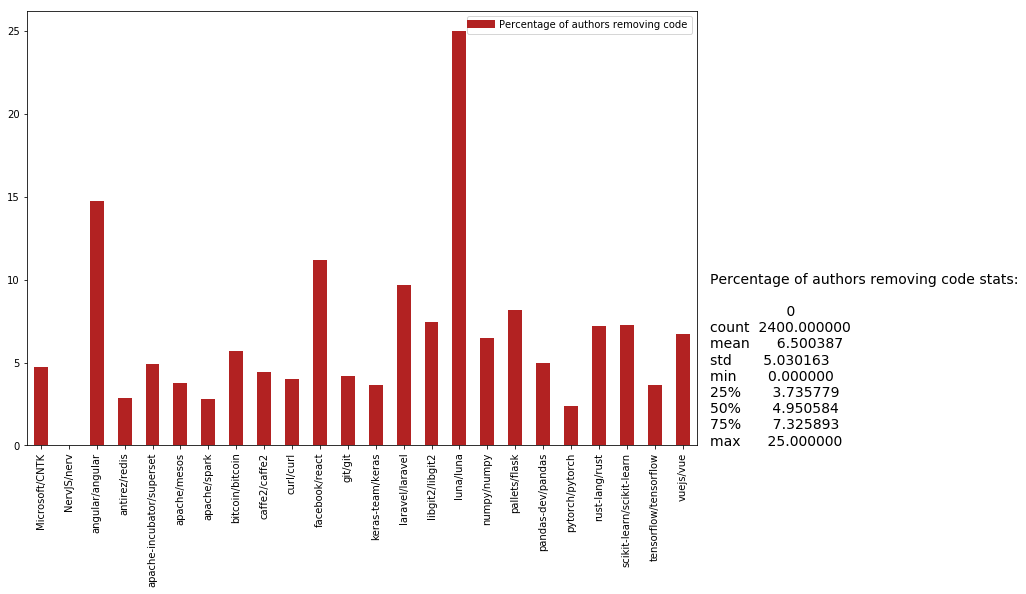

In [272]:
# show description of the result and bar chart of the proportion per project
(pd.DataFrame(role_prop, index = [0])*100).T.plot(kind = 'bar', figsize = (12,8), color='#B22222');
custom_lines = [Line2D([0], [0], color='#B22222', lw=8)]
plt.legend(custom_lines, ['Percentage of authors removing code'])
plt.text(24, 0, 'Percentage of authors removing code stats:\n\n{}'.format(
   pd.DataFrame(role_prop, index = [0]).T.describe()*100), fontsize=14);

This graph shows that the percentage of authors with a tendency to remove code is around 6.5% for the 24 projects in question.

**Most of the projects** are around this mean, except for the following 2 projects which affect the standard deviation:
- `luna` has a larger proportion of authors (25%) with a tendency to remove code, as it can be seen from the bar chart presented.
- `NervJS` has **no authors with a high tendency to remove code.**

However, looking at the number of commits per author for these 2 projects project (see below), this is actually caused by them having mainly a few authors (2 for `NervJS`, 8 for `luna`) who actually contribute to the project. This means the results are more easily skewed for this analysis. 

In [300]:
# Show the number of commits per author for NervJS and luna.
print('Commits per author for NervJS:')
tmp = commits_df[(commits_df.project == 'NervJS/nerv')].groupby('author_name').size()
display(tmp[tmp > 3])
print('---\n\nCommits per author for luna:')
tmp = commits_df[(commits_df.project == 'luna/luna')].groupby('author_name').size()
display(tmp[tmp > 3])

Commits per author for NervJS:


author_name
Li,Weitao      4
luckyadam    220
yuche        447
dtype: int64

---

Commits per author for luna:


author_name
Adam Szlachta         166
Kamil Figiela          32
LJK                    25
Marcin Kostrzewa      273
Marcin Mikołajczyk    124
Sylwia                 13
Wojciech Danilo       551
piotrMocz              86
dtype: int64

For these two projects, having **skewed results** is logical: a small number of authors (e.g. 2) leads to them **being responsible for all roles** -- that is, developing and refactoring code (i.e. there is no reliable measure of division of roles between the contributors).

---

<span style="background:lightgreen">Thus, these results provide **another common feature** among these **successful projects** and that is in relation to the **presence of a role among the authors**. This role being **refactoring code**, which on average is performed by 6.5% of the authors responsible for the given project.</span>

*<span style='color:green'> Analysis of number of files (per author per project): </span>*

For each commit, the **number of files** affected is provided. The **following steps** were then performed:
- For **each author**, the **average number of files** affected by a commit is computed.
- For **each project**, the **percentage of authors** changing on average more then 100 files per commit is computed.

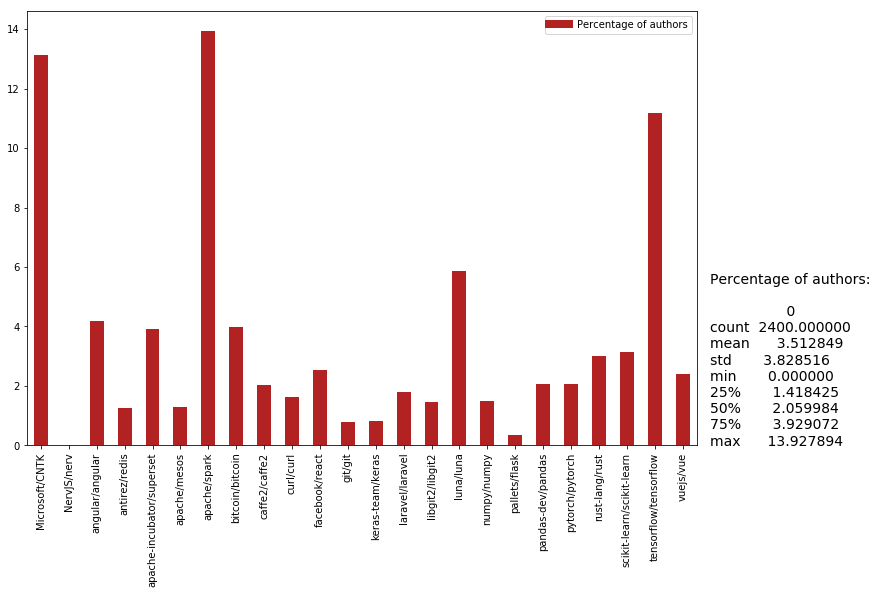

In [104]:
# compute average of files changed for each auther per commit
res = commits_df.groupby(['project','author_name']).nfiles.mean()

# compute proportion for each project
role_prop = dict()
for project in projects:
    role_prop[project] = 1- (res[res < 50][project].shape[0] / res[project].shape[0])

# show a description and a bar chart of the obtained data
(pd.DataFrame(role_prop, index = [0])*100).T.plot(kind = 'bar', figsize = (12,8), color='#B22222', legend=None);
plt.text(24, 0, 'Percentage of authors:\n\n{}'.format(
   pd.DataFrame(role_prop, index = [0]).T.describe()*100), fontsize=14);

**Add**

<span style="background:lightgreen">TODO</span>

*<span style='color:green'> Analysis of commit comments: </span>*

For each commit, a **commit comment** is provided. These commit messages are used to briefly explain **the function of the commit in question**. *For example, commits related to a certain bug would have terms related to the subject such as "bug", "fixed", "fixes" or "issue".* 

Thus, regular expression was used to **search for terms of interest** which are related to the following two topics:
- Commits related to **bugs and issues.** 
- Commits related to **merging operations.**

These two topics are of interest because, by considering the **proportion of unique authors involved in each**, one can study if such a **role** is present in these successful projects and in **what proportion**.

The following steps were performed for each of the two cases:
- The **number of commits** having the terms of interest was computed (using regular expression to account for spelling variations).
- The **number of unique authors** per project who authored these commits.
- The **percentage of authors** per project was then calculated.

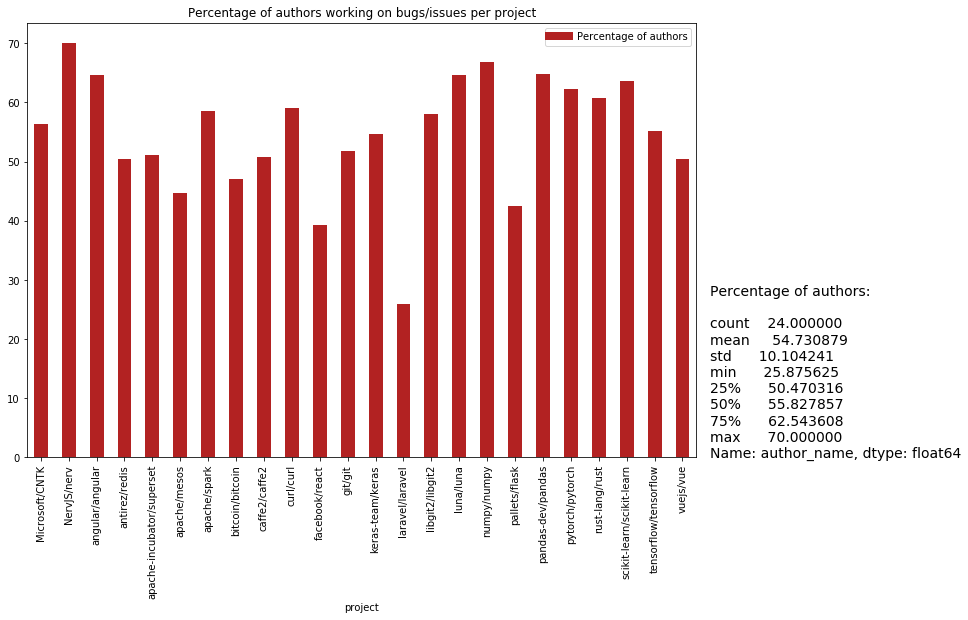

In [309]:
# define the terms to search for
REGEX = re.compile(r'\b(fixe|fix|bug|issue|problem)[sd]?\b', re.IGNORECASE)
# calculate the proportion of authors per project
comm_res = commits_df[commits_df.message.apply(lambda x: bool(re.search(REGEX, x)))][['project', 'author_name']].drop_duplicates().groupby('project').author_name.count()/commits_df[['project', 'author_name']].drop_duplicates().groupby('project').author_name.count()
# calculate the percentage
comm_res = comm_res*100

# present statistical description and bar chart for the data
comm_res.plot(kind = 'bar', figsize = (12,8), color='#B22222');
custom_lines = [Line2D([0], [0], color='#B22222', lw=8)]
plt.legend(custom_lines, ['Percentage of authors'])
plt.text(24, 0, 'Percentage of authors:\n\n{}'.format(
   comm_res.describe()), fontsize=14)
plt.title('Percentage of authors working on bugs/issues per project');

Considering the obtained results, on **average** for all 24 projects, **55% (stddev=10%)** of authors are involved with dealing with issues / bugs.

This shows the importance of dealing with issues and can be related to the success of a project. Furthermore, it shows that the role of dealing with issues is distributed over a wide range of the authors involved. This makes sense because each author can be responsible for a portion of the project, or some authors focus on issues that affect them personally.

<span style="background:lightgreen">Thus, these results provide **another common feature** among these **successful projects** and that is in relation to the **presence of a role among the authors**. This role being **dealing with issues / bugs**, which on average is performed by 55% of the authors responsible for the given project.</span>

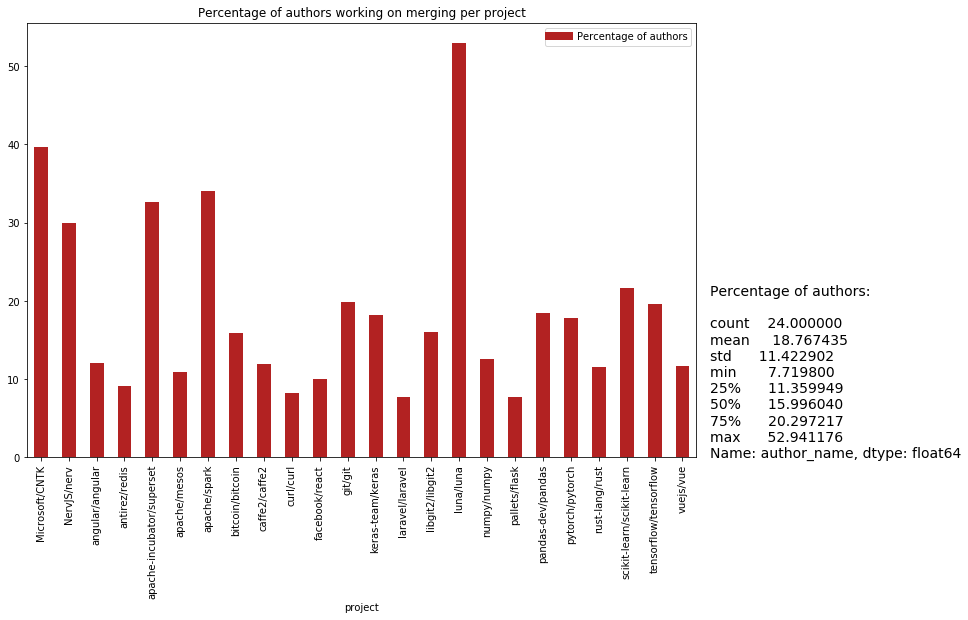

In [310]:
# define the terms to search for
REGEX = re.compile(r'\b(merge|merged|linke)[sd]?\b', re.IGNORECASE)
# calculate the proportion of authors per project
comm_res = commits_df[commits_df.message.apply(lambda x: bool(re.search(REGEX, x)))][['project', 'author_name']].drop_duplicates().groupby('project').author_name.count()/commits_df[['project', 'author_name']].drop_duplicates().groupby('project').author_name.count()
# calculate the percentage
comm_res = comm_res*100

# present statistical description and bar chart for the data
comm_res.plot(kind = 'bar', figsize = (12,8), color='#B22222');
custom_lines = [Line2D([0], [0], color='#B22222', lw=8)]
plt.legend(custom_lines, ['Percentage of authors'])
plt.text(24, 0, 'Percentage of authors:\n\n{}'.format(
   comm_res.describe()), fontsize=14)
plt.title('Percentage of authors working on merging per project');

Considering the obtained results: on **average** for all 24 projects, **19% (stddev=11%)** of authors are involved with dealing with merges.

(Note that `luna` being an outlier is not surprising due to the small number of authors it has, as explained above.)

<span style="background:lightgreen">Thus, these results provide **another common feature** among these **successful projects** and that is in relation to the **presence of a role among the authors**. This role being **dealing with merges**, which on average is performed by 19% of the authors responsible for the given project.</span>

### <span style='color:green'> 6.7 - Can we gain some insight from GitHub issues for a project?

Issues (including pull requests) are used in order to **keep track of tasks, enhancements, and bugs for a project**. Thus, analyzing the **features of the issues** for the set of successful projects in question may provide **certain insights or patterns** shared among them.

*<span style='color:green'> Analysis of the percentage of closed issues per project: </span>*

The **percentage of closed issues** per project was calculated and the results shown below.

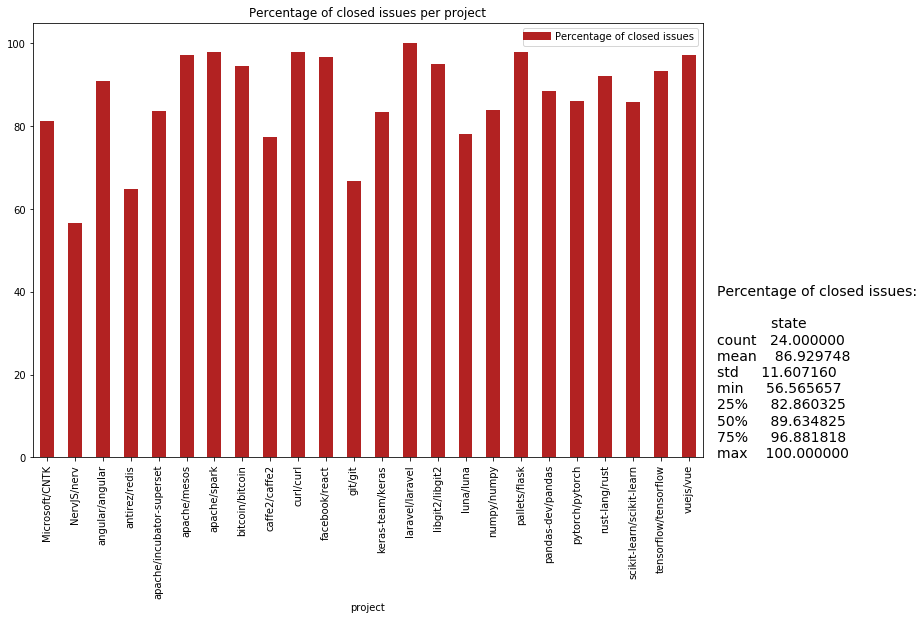

In [311]:
prec_closed_issues = pd.DataFrame(issues_df[issues_df['state'] == 'closed'].groupby('project').state.count()/issues_df.groupby('project').state.count()*100)

# present statistical description and bar chart for the data
prec_closed_issues.plot(kind = 'bar', figsize = (12,8), color='#B22222');
custom_lines = [Line2D([0], [0], color='#B22222', lw=8)]
plt.legend(custom_lines, ['Percentage of closed issues'])
plt.text(24, 0, 'Percentage of closed issues:\n\n{}'.format(
   prec_closed_issues.describe()), fontsize=14)
plt.title('Percentage of closed issues per project');

Considering the obtained results: on **average** for all 24 projects, **87% (stddev=11%)** of issues are closed.

<span style="background:lightgreen">Thus, these results provide **another common feature** among these **successful projects** and that is in relation to **dealing with closed issues**. On average, 87% of issues are closed, which is a good indicator of a project's activity.  
This relates to the interactiveness of the project with its community, including bug reports/feature requests (issues) and community contributions (pull requests) solving bugs/adding features.  
On one hand, this directly enhances the project by solving present issues or adding features. On the other hand, this indirectly incentivizes the community to keep on contributing, either in the form of reporting issues or sending pull requests.
</span>

*<span style='color:green'> Analysis of Average resolution time: </span>*

The **resolution time** for a given issue is the time it took to close the issue. It is an important measure of the responsivity of the authors to the community and the activity towards solving problems and further improving the project.

It was computed for each of the given issues as the difference between the time it was opened and the time it was closed. (Re-opened issues were not considered in this category). **The average resolution time** was then computed for each project and the data represented below (statistical description and bar chart).

In [328]:
issues_df['response_time'] = issues_df['closed_at'] - issues_df['created_at']
response_time = issues_df[issues_df['state'] == 'closed']
response_time_res = response_time.groupby('project').response_time.describe()
response_time_res = response_time_res.T
response_time_res

project,Microsoft/CNTK,NervJS/nerv,angular/angular,antirez/redis,apache/incubator-superset,apache/mesos,apache/spark,bitcoin/bitcoin,caffe2/caffe2,curl/curl,...,libgit2/libgit2,luna/luna,numpy/numpy,pallets/flask,pandas-dev/pandas,pytorch/pytorch,rust-lang/rust,scikit-learn/scikit-learn,tensorflow/tensorflow,vuejs/vue
count,2831,56,24598,3607,5327,307,22614,13741,1987,3198,...,4637,268,10415,2929,21052,12205,51620,10818,22102,8345
mean,84 days 21:11:52.377251,8 days 03:46:09.732142,39 days 21:09:49.182331,174 days 12:40:45.994455,57 days 01:27:58.462924,105 days 11:32:05.019543,23 days 17:53:44.347085,60 days 14:03:47.368896,27 days 12:37:39.664821,22 days 15:57:40.478424,...,42 days 12:33:39.650420,35 days 10:49:38.227611,80 days 04:48:27.183005,100 days 17:55:58.956640,76 days 01:22:49.109823,12 days 20:39:52.688897,65 days 06:22:33.247132,86 days 10:07:32.747088,35 days 19:57:41.608496,8 days 19:56:55.712282
std,137 days 05:20:03.746133,24 days 06:51:16.147308,100 days 05:47:22.405229,383 days 23:24:57.963503,136 days 23:11:05.061088,220 days 01:47:52.346500,66 days 16:56:21.014547,171 days 23:28:41.830646,75 days 18:08:56.980277,69 days 21:02:34.499017,...,136 days 03:17:53.082901,77 days 17:48:05.455787,253 days 07:25:49.885542,293 days 23:40:35.666705,239 days 12:19:43.319234,43 days 23:53:26.197908,173 days 08:15:55.519553,233 days 12:47:11.152219,85 days 03:48:08.850573,42 days 05:57:48.472254
min,0 days 00:00:04,0 days 00:00:07,0 days 00:00:05,0 days 00:00:05,0 days 00:00:02,0 days 00:00:13,0 days 00:00:02,0 days 00:00:04,0 days 00:00:05,0 days 00:00:10,...,0 days 00:00:04,0 days 00:00:03,0 days 00:00:00,0 days 00:00:04,0 days 00:00:04,0 days 00:00:04,0 days 00:00:00,0 days 00:00:04,0 days 00:00:06,0 days 00:00:00
25%,1 days 14:46:14.500000,0 days 04:18:02.500000,0 days 05:37:02.500000,0 days 06:22:32.500000,0 days 07:08:48.500000,0 days 01:25:58.500000,0 days 13:39:38.500000,0 days 16:17:30,0 days 04:52:48,0 days 07:28:52.750000,...,0 days 04:32:51,0 days 05:59:10.250000,0 days 00:39:25,0 days 00:55:47,0 days 06:09:00,0 days 03:22:38,0 days 18:59:43.750000,0 days 07:14:35.250000,0 days 08:25:03,0 days 00:19:15
50%,11 days 20:59:13,1 days 09:16:19,2 days 04:06:33.500000,4 days 22:29:38,1 days 22:56:12,2 days 14:12:11,2 days 11:34:18,4 days 12:56:50,1 days 09:49:28,1 days 09:33:39,...,2 days 02:20:59,3 days 23:47:17,0 days 15:45:44,0 days 21:24:23,2 days 07:53:55.500000,0 days 22:34:56,3 days 09:58:10,3 days 02:13:58,2 days 20:39:09,0 days 02:54:47
75%,109 days 06:35:58,5 days 12:40:58.750000,20 days 11:06:38.500000,119 days 01:42:57.500000,15 days 17:07:01.500000,66 days 13:06:05,12 days 00:02:16.250000,31 days 22:18:24,9 days 15:51:18,9 days 08:36:50.750000,...,15 days 06:47:52,28 days 16:16:37.250000,11 days 02:34:00,27 days 20:43:36,22 days 20:50:35,5 days 17:50:29,27 days 12:14:22.500000,34 days 03:03:10,26 days 01:09:30,0 days 22:31:52
max,769 days 01:49:39,171 days 05:19:05,1293 days 01:47:57,2410 days 09:05:50,737 days 09:42:39,1054 days 08:45:09,1016 days 12:46:03,2485 days 21:28:59,595 days 14:16:43,993 days 05:55:00,...,1534 days 09:11:43,461 days 17:43:59,2291 days 04:12:01,2343 days 14:37:20,2509 days 19:20:39,683 days 16:34:18,2393 days 14:49:48,2365 days 21:44:01,1094 days 05:24:15,721 days 00:39:27


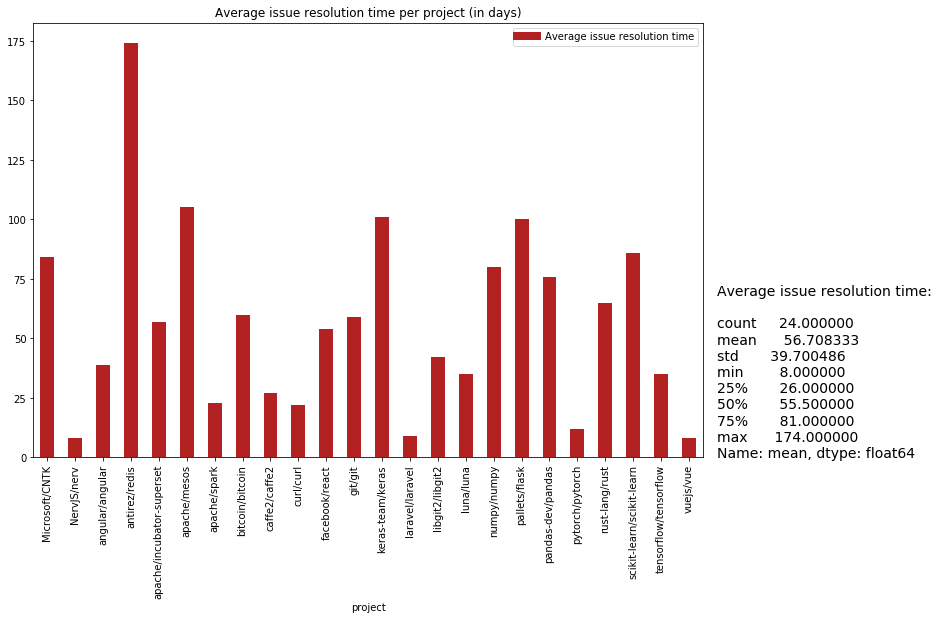

In [329]:
# present statistical description and bar chart for the data
response_time_res.loc['mean',].apply(lambda td: td.days).plot(kind = 'bar', figsize = (12,8), color='#B22222');
custom_lines = [Line2D([0], [0], color='#B22222', lw=8)]
plt.legend(custom_lines, ['Average issue resolution time'])
plt.text(24, 0, 'Average issue resolution time:\n\n{}'.format(
   response_time_res.loc['mean',].apply(lambda td: td.days).describe()), fontsize=14);
plt.title('Average issue resolution time per project (in days)');

Considering the obtained results: on **average** for all 24 projects, issues take **57 days (stddev=40)** to be resolved. This is highly variable from one project to another, with some projects being much faster in resolving issues (a couple of weeks), and other beings much slower (a few months).

The big range of the resolution time is likely due to the nature of the project and its issues, some projects/issues being inherently more complex than others. This means that issues require more time to properly debug and fix. Still, the projects are responsive in most cases, with the 2nd quartile (50%) of average issue resolution time being a couple of months on average. This is acceptable considering the amount of time required to inquire about the issue, debug it, fix it and test the final outcome.

<span style="background:lightgreen">Thus, these results provide **another common feature** among these **successful projects** and that is in relation to **the average time required to resolve issues**. On average, most issues are resolved within a couple of months, which is a good indicator of a project's activity and responsiveness.  
</span>

*<span style='color:green'> Analysis of users who handle a lot of issues: </span>*

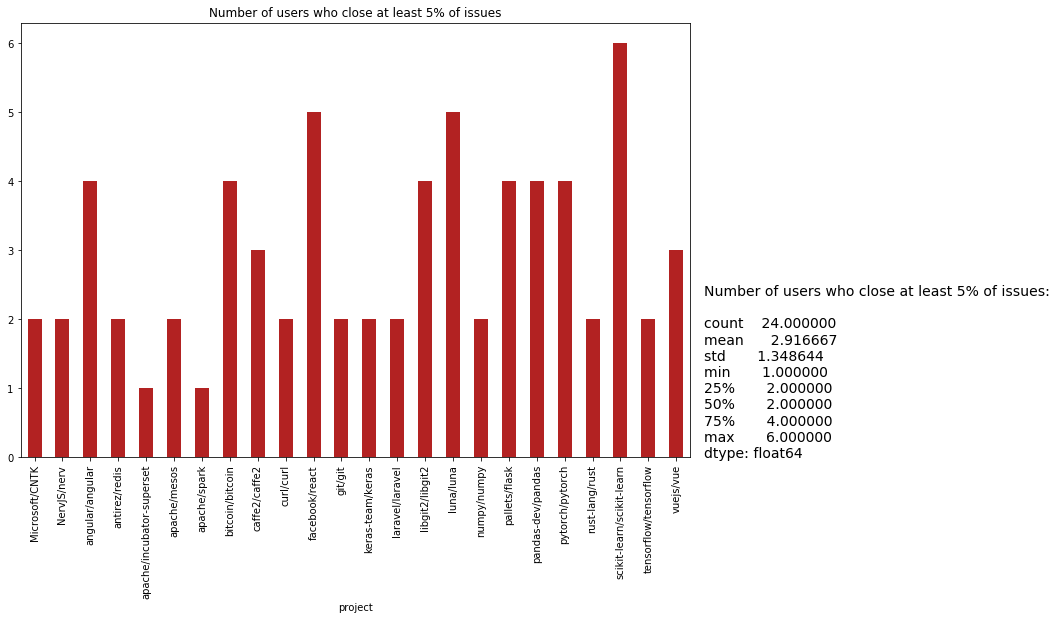

In [64]:
closed_by_user = issues_df.groupby(['project', 'closed_by']).size() / issues_df.groupby(['project']).size()
closed_by_user = closed_by_user[closed_by_user > 0.05].groupby('project').count()
closed_by_user.plot.bar(figsize = (12,8), color='#B22222');
plt.text(24, 0, 'Number of users who close at least 5% of issues:\n\n{}'.format(
    closed_by_user.describe()), fontsize=14)
plt.title('Number of users who close at least 5% of issues');

Considering the obtained results: on **average** for all 24 projects, **a couple of users (mean=3, stddev=1.3) close a sizeable amount of issues**.

<span style="background:lightgreen">Thus, these results provide **another common feature** among these **successful projects** and that is in relation to the **presence of a role among the authors**. This role being **dealing with the issues reported by the community** (on GitHub). On average, a few users per project (around 3) are responsible for this.</span></span>

### <span style='color:green'> 6.8 - Can we relate the success / popularity to a responsive / helpful community (e.g. StackOverflow / Reddit subreddits)? </span>

In [70]:
# load stackoverflow tag data
tag_stackoverflow_df = pd.read_csv('./data/Tags.csv',header=0, index_col=0, names=['Tag_Name','Count','Excerpt_Post_Id','Wiki_Post_ID'])
display(tag_stackoverflow_df.head(5))

,Tag_Name,Count,Excerpt_Post_Id,Wiki_Post_ID
1,.net,276857,3624959.0,3607476.0
2,html,789778,3673183.0,3673182.0
3,javascript,1723731,3624960.0,3607052.0
4,css,563816,3644670.0,3644669.0
5,php,1245650,3624936.0,3607050.0


In [71]:
tag_stackoverflow_df['Tag_Name'].shape

(53806,)

In [72]:
tag_stackoverflow_df['caffee2' == tag_stackoverflow_df['Tag_Name']].shape[0]

0

In [82]:
tags = ['redis', 'flask', 'numpy', 'pandas', 'curl', 'libgit2', 'bitcoin', 'git', 'laravel', 'reactjs',
        'mesos', 'vue.js', 'apache-spark', 'angular', 'keras', 'caffe2', 'apache-superset', 'tensorflow',
        'cntk', 'pytorch']
tag_stackoverflow_df[tag_stackoverflow_df.Tag_Name.isin(tags)].sort_values(by='Count')
# No occurences: NervJS/nerv, luna/luna

,Tag_Name,Count,Excerpt_Post_Id,Wiki_Post_ID
125979,caffe2,113,43512633.0,43512632.0
129476,apache-superset,114,47074112.0,47074111.0
66800,libgit2,457,5435109.0,5435108.0
118937,cntk,487,36423352.0,36423351.0
95191,mesos,1163,18393042.0,18393041.0
67868,bitcoin,1396,6242245.0,6242244.0
124253,pytorch,1794,41778328.0,41778327.0
112144,keras,12523,30409715.0,30409714.0
43464,redis,14958,4742844.0,4742843.0
54712,flask,24906,3625312.0,3625311.0
